# Estudios analíticos

En este tipo de estudios se trata de buscar una relación causa-efecto (efecto-causa) entre las variables medidas. Al igual que en los estudios descriptivos, habrá que dar descripción pormenorizada del tipo de variables. Recordamos:

1. Realizar las transformaciones necesarias.
2. Describir a los sujetos estudiados. Sintetizar las principales características de la muestra:
    1. ¿Se adecua la muestra al problema planteado?
	2. ¿Para qué tipo de sujetos se van a obtener los resultados?
	3. ¿Puede extrapolarse los resultados del estudio a otras poblaciones?
	4. ¿Podrá replicarse el estudio por otros investigadores?
3. Evaluar la representatividad de la muestra.
4. Estimar el valor(es) del parámetro(s) de interés y si es posible calcular el intervalo de confianza de dicha estimación.
5. ¿Es necesario realizar un análisis de subgrupos?
6. Detectar la relación entre variables estadísticas. 
7. Medir la fortaleza de la relación entre variables estadísticas.
8. Calcular, si fuera necesario, un modelo que explique una variable en función de otra.

<figure>
    <img src="https://raw.githubusercontent.com/AngelBerihuete/datasets/master/cuadroVariables.png">
</figure> 

# Relación <span style="color:green"> Categórica x Categórica </span> 

In [1]:
%pylab inline 
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

import scipy.stats as st
import pandas as pd
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = sm.datasets.get_rdataset("Arthritis", "vcd").data
df.head(15)

,ID,Treatment,Sex,Age,Improved
0,57,Treated,Male,27,Some
1,46,Treated,Male,29,None
2,77,Treated,Male,30,None
3,17,Treated,Male,32,Marked
4,36,Treated,Male,46,Marked
5,23,Treated,Male,58,Marked
6,75,Treated,Male,59,None
7,39,Treated,Male,59,Marked
8,33,Treated,Male,63,None
9,55,Treated,Male,63,None


Podemos representar los datos mediante un gráfico de mosaico:

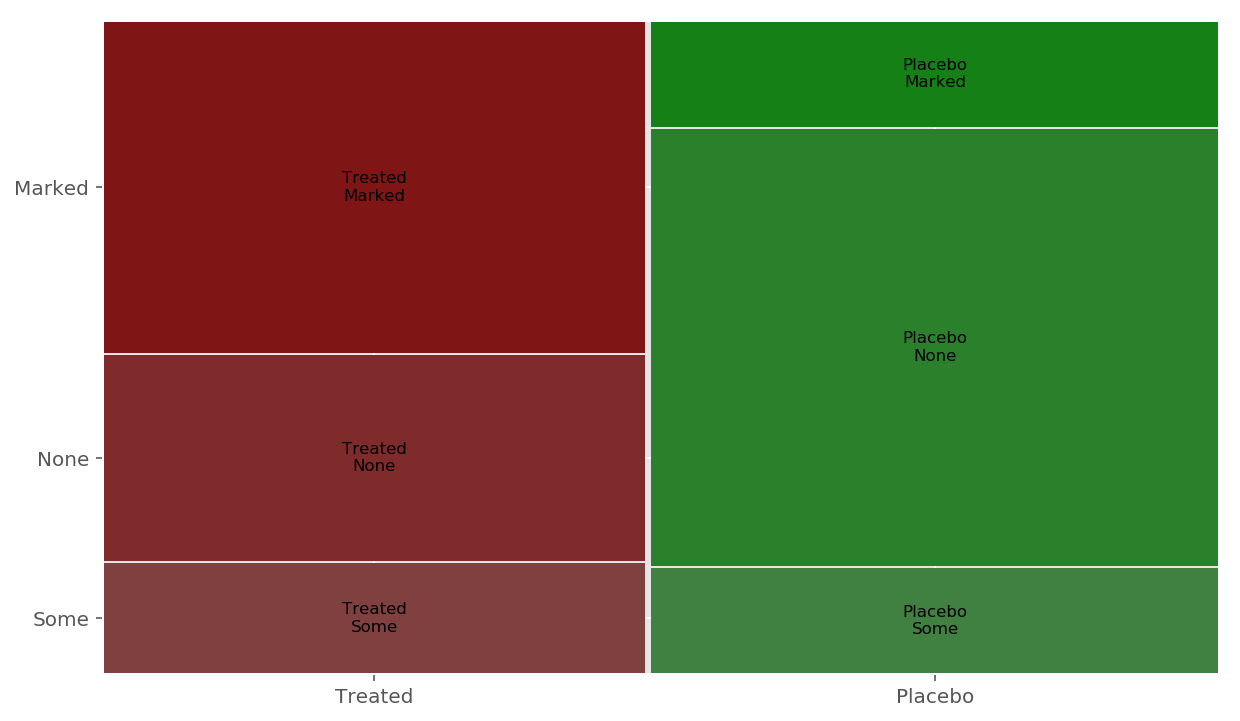

In [4]:
from statsmodels.graphics.mosaicplot import mosaic
data = df[["Treatment", "Improved"]]

fig, _ = mosaic(data, index=["Treatment", "Improved"])

In [5]:
table = sm.stats.Table.from_data(data)

La tabla de contingencia original es:

In [10]:
table.table_orig

Improved,Marked,None,Some
Treatment,,,
Placebo,7,29,7
Treated,21,13,7


In [11]:
table.marginal_probabilities

(Treatment
 Placebo    0.511905
 Treated    0.488095
 dtype: float64,
 Improved
 Marked    0.333333
 None      0.500000
 Some      0.166667
 dtype: float64)

Los valores esperados en caso de que las variables fueran independientes serían:

In [12]:
table.fittedvalues

Improved,Marked,None,Some
Treatment,,,
Placebo,14.333333,21.5,7.166667
Treated,13.666667,20.5,6.833333


Cuando las variables cualitativas no tienen orden (nominales) la prueba $\chi^2$ es la más utilizada para comprobar la independiencia entre las variables:

$$\begin{cases}
            H_0 :& \text{Las variables son independientes} \\
            H_1 :&  \text{Las variables NO son independientes}
\end{cases}$$

__Asumimos__:


1. Las celdas son recuentos, no porcentajes.
2. Los niveles del factor (grupos) a testear son mutuamente excluyentes.
3. Cada participante contribuye solo a una celda dentro de la tabla.
4. Los grupos a testear deben ser independientes.
5. El valor esperado de las celdas, si las variables fueran independientes, debe ser mayor que 5,


In [13]:
print(table.test_nominal_association())

df          2
pvalue      0.0014626434089526352
statistic   13.055019852524108


Este test debe cumplir que las frecuencias esperadas en cada casilla sean mayor que 5, condición que se cumple como hemos visto en ```table.fittedvalues```. Si no se cumpliera, mejor utilizar el test exacto de Fisher. 

En caso de que las filas y columnas estén ordenadas la prueba de tendencia Cochran-Armitage es __más potente__ (identificar la no independencia cuando verdaderamente son no independientes)

In [14]:
print(table.test_ordinal_association())

null_mean   34.166666666666664
null_sd     3.167089382058727
pvalue      0.023644578093923983
statistic   27.0
zscore      -2.262855828214126


Para medir la fortaleza de la asociación, vamos a utilizar el coeficiente V de Cramer, C de contingencia, o la $\phi^2$ de Pearson, cuyas fórmula son

$$V= \sqrt{\cfrac{\cfrac{\chi^2}{n}}{\min \{ k-1, r-1\}}}, \quad C = \sqrt{\frac{\chi^2}{\chi^2 + n}} \quad \phi^2 = \frac{\chi^2}{n}$$

siendo $k$ y $r$ el número de filas y columnas de la tabla de contingencia. Ver la página de Wikipedia [Cramer's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V), [Phi coefficient](https://en.wikipedia.org/wiki/Phi_coefficient)

In [15]:
def cramersV(table):
    nobs = table.table_orig.sum().sum()
    nrows, ncols = table.table_orig.shape
    chisquared = table.test_nominal_association().statistic 
    phi2 = chisquared/nobs
    C = np.sqrt(chisquared/(chisquared+nobs))
    V = np.sqrt(phi2/min(nrows-1, ncols-1))
    return [V, C, phi2]

V, C, phi2 = cramersV(table)
print('V de cramer=',V,'\n','Coeficiente contingencia=',C,'\n','Coeficiente phi de Pearson=',phi2)

V de cramer= 0.3942295054993213 
 Coeficiente contingencia= 0.3667581445222345 
 Coeficiente phi de Pearson= 0.1554169030062394


### Interpretación de los resultados

Hay una asociación/relación estadísticamente significativa entre el tratamiento y la mejora del paciente $\chi^2 (2) = 13.055$, $p-valor = 0.0014 < \alpha = 0.01$. La fortaleza de esa relación es pequeña, la V de Cramer = 0.3942. Por tanto, sería necesario realizar test post hoc entre los grupos para detectar dónde están las diferencias (__análsis de subgrupos__).

Realizaremos un análisis de subgrupos mediante múltiples tests Chi-cuadrado 2x2 utilizando el p-valor ajustado de Bonferroni. Este ajuste de Bonferroni es necesario porque comparar multiples niveles (categorías) una contra otra, el error de falso positivo se multiplica por cada test, es decir, si el primer test el falso positivo es 0.05 (5%), después de realizar el segundo test tendremos un 10% de posibilidades de falso positivo, y así sucesivamente. En nuestro caso, al realizar 3 test Chi-cuadrado 2x2 (Marked, None, Some), consideraremos nuestro nivel de significación $0.05/3=0.017$. Así pues, para que un par sea significativo, el p-valor debe ser menor de 0.017.

Lo primero que hacemos es crear variables ficticias a partir de las que ya tenemos:

In [16]:
dummies = pd.get_dummies(data['Improved'])
dummies.head()

,Marked,None,Some
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


Ahora realizamos cada uno de los test con dichas variable ficticias:

In [17]:
for series in dummies:
    nl = "\n"    
    crosstab = pd.crosstab(dummies[f"{series}"], df['Treatment'])
    print(crosstab, nl)
    chi2, p, dof, expected = st.chi2_contingency(crosstab)
    print(f"Chi2 value= {chi2}{nl}p-value= {p}{nl}Degrees of freedom= {dof}{nl}")

Treatment  Placebo  Treated
Marked                     
0               36       20
1                7       21 

Chi2 value= 10.011627906976745
p-value= 0.0015555496486971453
Degrees of freedom= 1

Treatment  Placebo  Treated
None                       
0               14       28
1               29       13 

Chi2 value= 9.33862733976177
p-value= 0.002243735258044318
Degrees of freedom= 1

Treatment  Placebo  Treated
Some                       
0               36       34
1                7        7 

Chi2 value= 0.03811684628474195
p-value= 0.8452086973905258
Degrees of freedom= 1



Utilizando el p-valor ajustado de Bonferroni 0.017, 2 de las 3 comparaciones han resultado significativas: Mejora marcada con tratamiento, y Ninguna mejora con tratamiento. 

Para finalizar calculamos la odds ratio, o cociente de razones, para medir la incidencia del tratamiento en la mejora del paciente.

In [18]:
table.table_orig

Improved,Marked,None,Some
Treatment,,,
Placebo,7,29,7
Treated,21,13,7


In [19]:
local_table = sm.stats.Table2x2(np.asarray([[7, 29], [21, 13]]))

In [20]:
local_table.summary()

,Estimate,SE,LCB,UCB,p-value
Odds ratio,0.149,,0.051,0.439,0.001
Log odds ratio,-1.901,0.549,-2.978,-0.824,0.001
Risk ratio,0.315,,0.154,0.644,0.002
Log risk ratio,-1.156,0.365,-1.871,-0.440,0.002


Es importante destacar:

* La odds ratio oscila entre 0 e infinito.
* Cuando la odds ratio es 1 indica ausencia de asociación entre las variables.
* Los valores menores de 1 señalan una asociación negativa entre las variables y los valores mayores de 1 indican asociación positiva entre las variables.
* Cuanto más se aleje la odds ratio de 1, más fuerte es la relación.

En nuestro caso la odds ratio es 0.149. Además es estadísticamente significativa ($p-valor = 0.001 < \alpha = 0.05$). Por tanto, para una persona que no haya notado mejora en el tratamiento habrá 6.7 (1/0.149) más posibilidades de haberse tratado con placebo.

# Relación <span style="color:green"> Categórica x Numérica </span> 

Para investigar la relación entre una variable categórica y una numérica, debemos penesar en la variable categórica como una variable que divide a la población en dos o más subpoblaciones. Por ejemplo, si estamos investigando el salario de los empleados de cierta empresa, la variable categórica __sexo__ hará que dividamos la variable salario en diferentes categorías.

## Contrastes paramétricos en dos poblaciones normales DEPENDIENTES

**Asumimos** que se las variables se distribuyen como $X\sim \mathcal{N}(\mu_1,\sigma_1)$,
$Y \sim \mathcal{N}(\mu_2,\sigma_2)$. 

En el caso de tener **muestras dependientes/pareadas**, es decir, mismos
individuos a los que se ha medido una variable antes y después de cierto
tratamiento, _procederemos restando ambas variables y aplicando un
contraste para una población de los que hemos visto en la sección
anterior_.

Para un contraste bilateral

$$\begin{cases}
            H_0 :& \mu_1 = \mu_2 \\
            H_1 :&  \mu_1 \neq \mu_2
\end{cases}
\qquad \mbox{ equivalente } \qquad
\begin{cases}
            H_0 :& \mu_1 - \mu_2 = \mu_{diff} = 0 \\
            H_1 :&  \mu_1 - \mu_2 =  \mu_{diff} \neq 0
\end{cases}
$$

Por ejemplo, queremos contrastar si hay diferencias en el salario medio de la población de trabajadores ANTES Y DESPUÉS de una subida salarial. Para ello vamos a simular datos a partir de dos variables aleatorias Normales. 

In [21]:
X1 = st.norm(loc=7000, scale=1000)
X2 = st.norm(loc=8000, scale=1000)

# Generamos 1000 datos aleatoriamente de dicha distribución.
dataset = pd.DataFrame({'antes': X1.rvs(500), 'despues': X2.rvs(500)})

dataset.describe()

,antes,despues
count,500.000000,500.000000
mean,6983.265395,7978.119651
std,990.204427,968.077375
min,3875.179271,4687.884549
25%,6346.775140,7333.262505
50%,7014.970743,7969.828172
75%,7586.073006,8645.633557
max,10267.116888,10792.295542


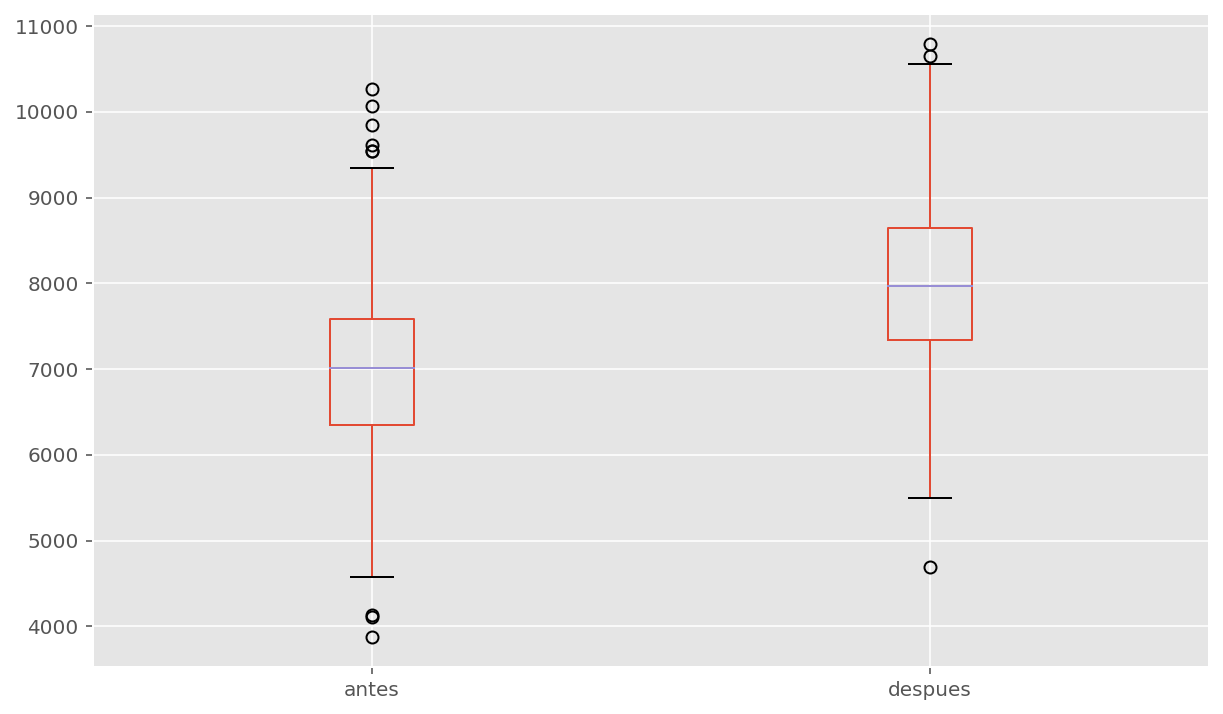

In [22]:
dataset.boxplot();

__Primera hipótesis__ ¿Provienen los datos de una distribución normal?

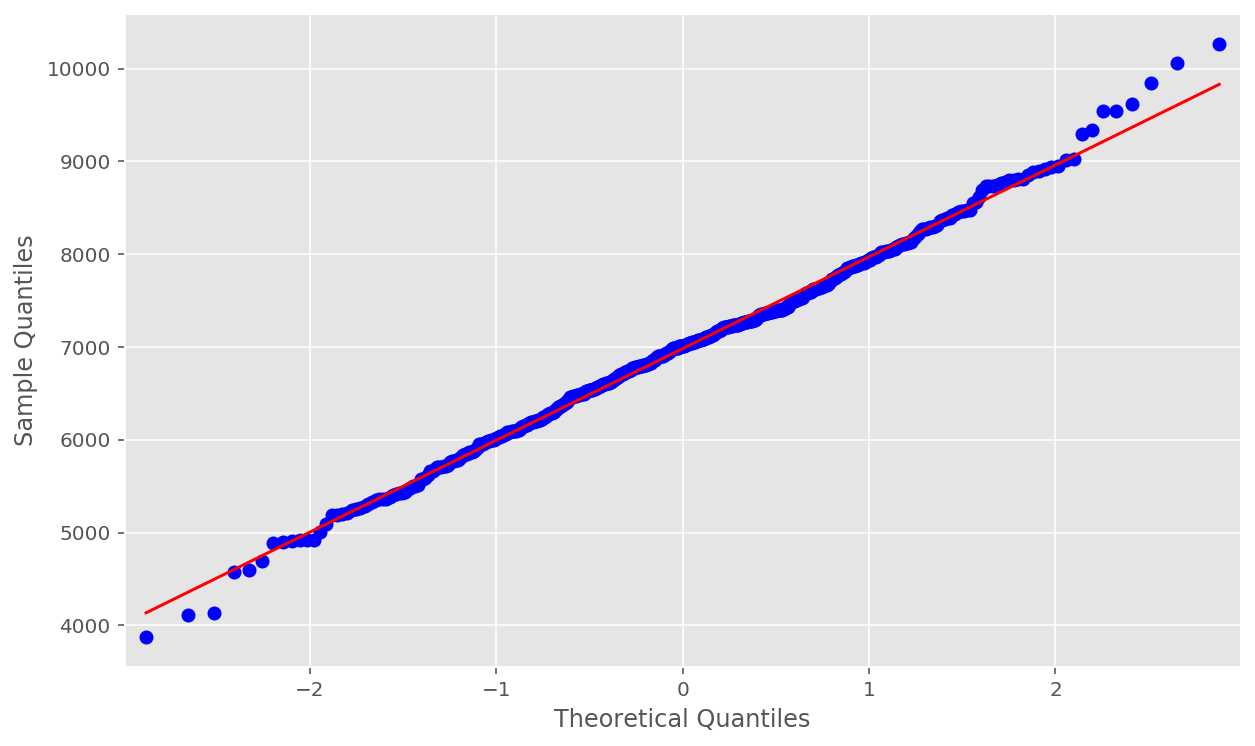

In [23]:
import scipy.stats as st
from statsmodels.graphics.gofplots import qqplot

qqplot(dataset.antes, line='s');

In [24]:
W, p = st.shapiro(dataset.antes)
print('Estadístico=%.3f, p-valor=%.3f' % (W, p))

Estadístico=0.997, p-valor=0.423


In [25]:
W, p = st.shapiro(dataset.despues)
print('Estadístico=%.3f, p-valor=%.3f' % (W, p))

Estadístico=0.998, p-valor=0.705


En ambos casos la prueba de Shapiro-Wilk es no significativa, y por lo tanto puede suponerse que ambas poblaciones poblaciones provienen de distribuciones Normales.

Una vez comprobadas las hipótesis hacemos el contraste:

$$\begin{cases}
            H_0 :& \mu_{antes} = \mu_{despues} \\
            H_1 :&  \mu_{antes} \neq \mu_{despues}
\end{cases}$$

In [26]:
T, p = st.ttest_rel(dataset.antes, dataset.despues)
print('Estadístico=%.3f, p-valor=%.3f' % (T, p))

Estadístico=-15.894, p-valor=0.000


La prueba t-test para muestras pareadas es significativa/nosignificativa (ver los valores obtenidos del test), por tanto hay/nohay evidencia, con la muestra suministrada, de una diferencia significativa antes y después de la subida salarial.

Podríamos haber planteado 

$$\begin{cases}
            H_0 :& \mu_{antes} \geq \mu_{despues} \\
            H_1 :&  \mu_{antes} < \mu_{despues}
\end{cases}$$

In [28]:
T, p = st.ttest_rel(dataset.antes, dataset.despues)
print('Estadístico=%.3f, p-valor=%.3f' % (T, p/2.))

Estadístico=-15.894, p-valor=0.000


Dados los valores $p$ y $T$ de un test bilateral, puede rechazar la hipótesis nula de un test unilateral _mayor que_ si $p/2 < \alpha$ y $T > 0$, y un tes unilateral _menor que_ cuando  $p/2 < \alpha$ y $T < 0$.

## Contrastes paramétricos en dos poblaciones normales INDEPENDIENTES

En el caso de tener **muestras independientes**, es decir, una variable
en estudio para dos poblaciones diferentes, **asumimos** que se
distribuyen como $X\sim \mathcal{N}(\mu_1,\sigma_1)$,
$Y \sim \mathcal{N}(\mu_2,\sigma_2)$ ($X$ e $Y$ independientes).
Entonces

1.  Contrastes para $\mu_1$ y $\mu_2$

    -   Conocemos $\sigma ^2_1$ y $\sigma ^2_2$. Debe utilizarse
        $d= \dfrac{\overline{x}-\overline{y}}{\sqrt{\frac{\sigma_1^2}{n}+\frac{\sigma_2^2}{m}}}$
        $$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
           \mu_1 = \mu_2 & \mu_1 \neq \mu_2 & \mbox{$d \geq z_{1- \alpha/2}$ ó $d\leq z_{\alpha/2}$}  \\
          \hline
        \mbox{$\mu_1 \leq \mu_2$ ó $\mu_1 = \mu_2$}  & \mu_1 > \mu_2 & d \geq z_{1- \alpha} \\
          \hline
        \mbox{$\mu_1 \geq \mu_2$ ó $\mu_1 = \mu_2$}  & \mu_1 < \mu_2 & d \leq z_{\alpha} \\
          \hline
        \end{array}$$

    -   Desconocemos $\sigma ^2_1$ y $\sigma ^2_2$, pero sabemos que $\sigma ^2_1 = \sigma^2_2$.
    Debe utilizarse $d=\dfrac{\overline{x}-\overline{y}}{\hat{S}_{conj}\sqrt{\frac{1}{n}+\frac{1}{m}}}$, siendo $\hat{S}_{conj}=\sqrt{\frac{(n-1)s_1^2+(m-1)s_2^2}{n+m-2}}$
$$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
           \mu_1 = \mu_2 & \mu_1 \neq \mu_2 & \mbox{$d \geq t_{n+m-2, 1- \alpha/2}$ ó $d\leq t_{n+m-2, \alpha/2}$} \\
          \hline
        \mbox{$\mu_1 \leq \mu_2$ ó $\mu_1 = \mu_2$}  & \mu_1 > \mu_2 & d \geq t_{n+m-2, 1- \alpha} \\
          \hline
        \mbox{$\mu_1 \geq \mu_2$ ó $\mu_1 = \mu_2$} & \mu_1 < \mu_2 & d \leq t_{n+m-2, \alpha} \\
          \hline
        \end{array}$$

    -   Desconocemos $\sigma ^2_1$ y $\sigma ^2_2$, pero sabemos que
        $\sigma ^2_1 \neq \sigma
        ^2_2$. Debe utilizarse $d=
        \dfrac{\overline{x}-\overline{y}}{\sqrt{\frac{s_1^2}{n}+\frac{s_2^2}{m}}}
        $ $$\begin{array}{|c|c|c|}
        \hline
          H_0 & H_1 & \mbox{Región crítica}  \\
          \hline\hline
           \mu_1 = \mu_2 & \mu_1 \neq \mu_2 & \mbox{$d \geq t_{n+m-2-g, 1- \alpha/2}$ ó $d\leq t_{n+m-2-g, \alpha/2}$}  \\
          \hline
        \mbox{$\mu_1 \leq \mu_2$ ó $\mu_1 = \mu_2$}  & \mu_1 > \mu_2 & d \geq t_{n+m-2-g, 1- \alpha} \\
          \hline
        \mbox{$\mu_1 \geq \mu_2$ ó $\mu_1 = \mu_2$}  & \mu_1 < \mu_2 & d \leq t_{n+m-2-g, \alpha} \\
          \hline
        \end{array}$$ siendo  $g= \dfrac{[(m-1)T_1-(n-1)T_2]^2}{(m-1)T_1^2+(n-1)T_2^2}$, $T_1= \dfrac{s_1^2}{n}$ y $T_2= \dfrac{s_2^2}{m}$

2.  Contrastes para $\sigma ^2_1$ y $\sigma ^2_2 $. Debe utilizarse $d=
    \frac{s_1^2}{s_2^2}$ $$\begin{array}{|c|c|c|}
    \hline
      H_0 & H_1 & \mbox{Región crítica}  \\
      \hline\hline
      \sigma_1^2 = \sigma_2^2 & \sigma_1^2 \neq \sigma_2^2 & \mbox{$d \geq F_{n-1,m-1,1- \alpha/2}$ ó $d\leq F_{n-1,m-1,\alpha/2}$}  \\
      \hline
    \mbox{$\sigma_1^2 \leq \sigma_2^2$ ó $\sigma_1^2 = \sigma_2^2$}  & \sigma_1^2 > \sigma_2^2 & d \geq F_{n-1,m-1,1- \alpha} \\
      \hline
    \mbox{$\sigma_1^2 \geq \sigma_2^2$ ó $\sigma_1^2 = \sigma_2^2$}  & \sigma_1^2 < \sigma_2^2 & d \leq F_{n-1,m-1,\alpha} \\
      \hline
    \end{array}$$


### Ejemplo

Utilizando las varibles que hemos definido anteriormente, pero suponiendo ahora que se han medido en individuos diferentes, es decir, tenemos dos poblaciones independientes:

$$\begin{cases}
            H_0 :& \mu_{hombres} = \mu_{mujeres} \\
            H_1 :&  \mu_{hombres} \neq \mu_{mujeres}
\end{cases}$$

__¡No puedo olvidar comprobar la normalidad y la igualdad de varianzas!__

In [3]:
X1 = st.norm(loc=7000, scale=1000)
X2 = st.norm(loc=8000, scale=1000)

sueldos_hombres = X1.rvs(500)  # Tamaño muestral 500
sueldos_mujeres = X2.rvs(300)  # Tamaño muestral 300

st.ttest_ind(sueldos_hombres, sueldos_mujeres, equal_var = True)
T, p = st.ttest_ind(sueldos_hombres, sueldos_mujeres, equal_var = True)
print('Estadístico=%.3f, p-valor=%.3f' % (T, p/2.))

Estadístico=-14.001, p-valor=0.000


### Ejemplo con datos reales

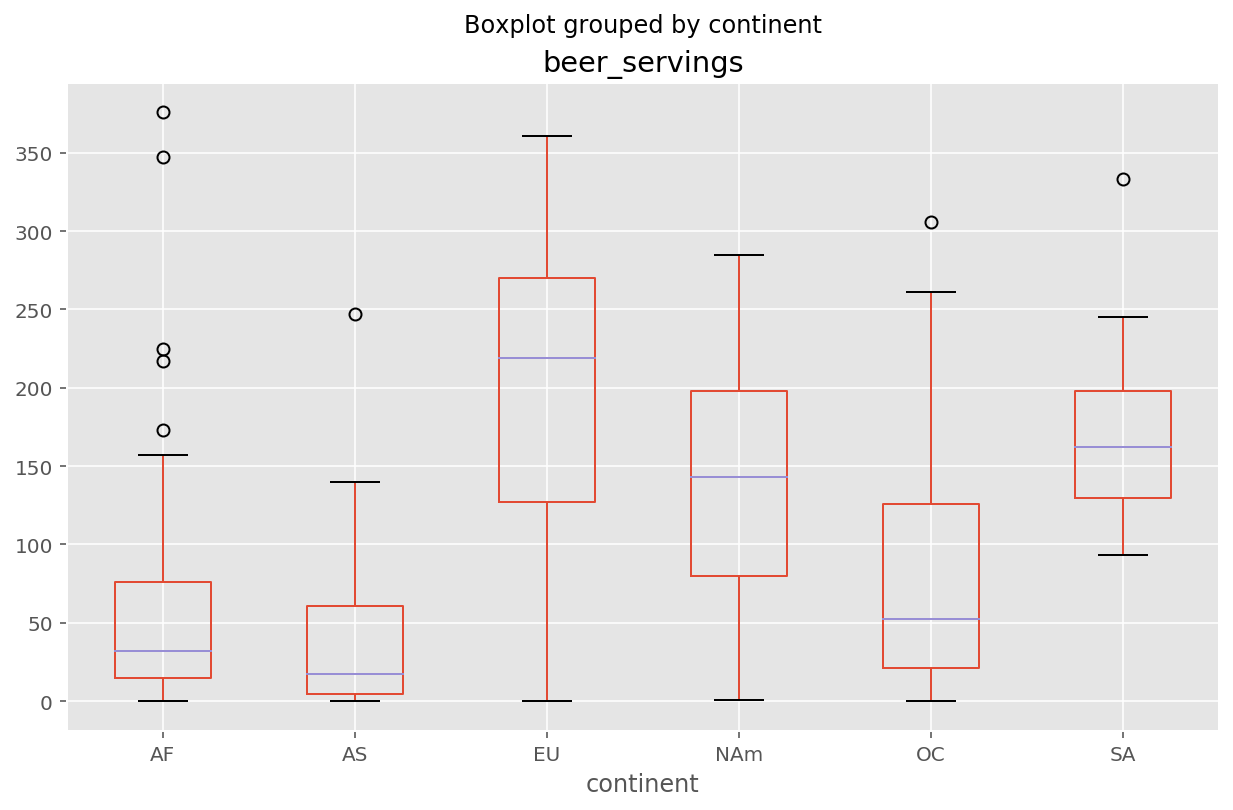

In [4]:
drinks = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT5/master/data/drinks.csv')
drinks.boxplot(column='beer_servings', by='continent');

In [5]:
muestra1 = drinks[drinks.continent=='EU']
muestra2 = drinks[drinks.continent=='AS']

st.ttest_ind(muestra1.beer_servings, muestra2.beer_servings) # underestimates p for unequal variances

Ttest_indResult(statistic=9.366080238479768, pvalue=7.991808688642694e-15)

In [6]:
st.ttest_ind(muestra1.beer_servings, muestra2.beer_servings, equal_var = False)

Ttest_indResult(statistic=9.430638509458626, pvalue=8.992991989304642e-14)

En cualquiera de las dos opciones, el contraste es significativo, por tanto hay evidencia, con la muestra suministrada para asegurar con un $\alpha = 5\%$ de que la media en la ración de cerveza es diferente en Europa y Asia.

Pero, ¿qué opción coger? ¿puedo suponer las varianzas iguales?

## Prueba para la igualdad de varianzas.

Sería conveniente realizar test robustos como el de __Levene o Barlett__ (en lugar de utilizar la prueba __F__ que es muy sensible a la normalidad de los datos):

In [7]:
st.bartlett(muestra1.beer_servings, muestra2.beer_servings)

BartlettResult(statistic=19.457273721338403, pvalue=1.0287531843081512e-05)

In [38]:
st.levene(muestra1.beer_servings, muestra2.beer_servings, center='mean') 
# También puede hacerse center='median' (default)
# Aplicar este test cuando haya desviaciones significativas de normalidad 

LeveneResult(statistic=21.94355534303793, pvalue=1.0282725458828434e-05)

En ambos casos el test es significativo, es decir, hay evidencia con la muestra suministrada para asegurar que las varianzas son diferentes. Y por tanto, en el contraste de medias habrá que utilizar ```equal_var=False```

### Prueba de normalidad

__¡Cuidado!__ ¿Se distribuyen los datos siguiendo una distribución normal?

/home/angel/anaconda3/envs/modulo2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:59: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  n, bins, patches = ax.hist(y, bins=bins, bottom=bottom, **kwds)


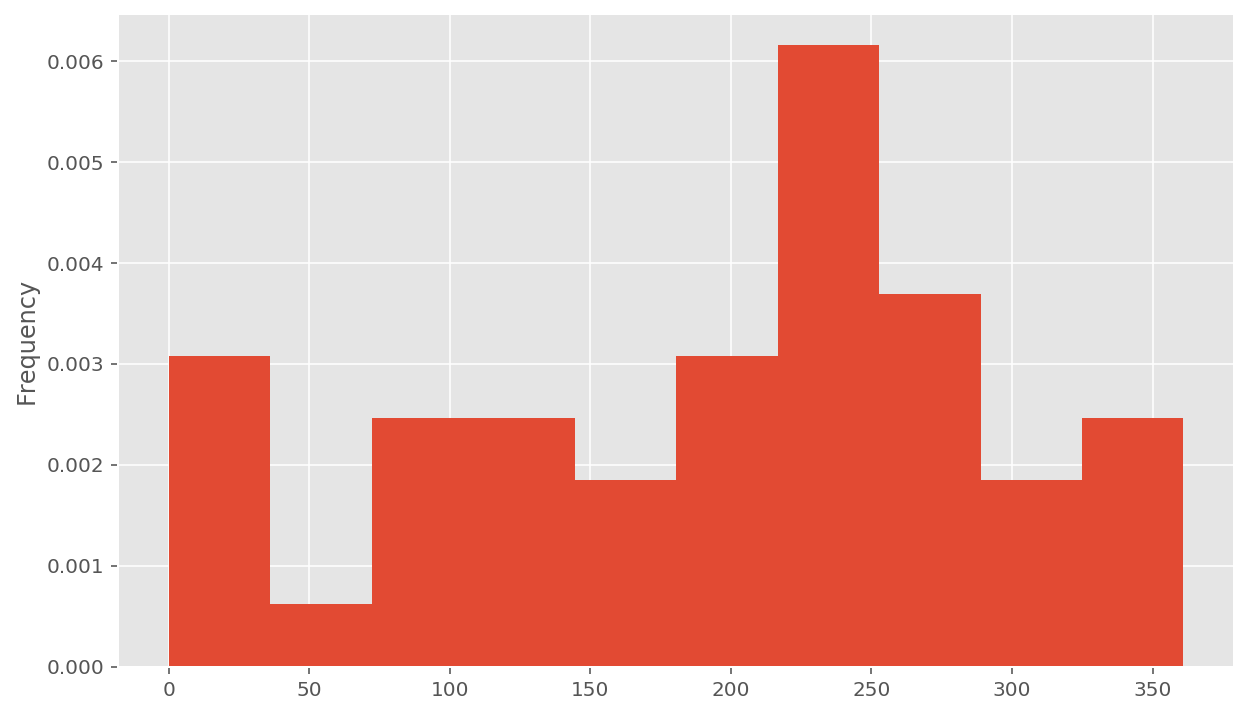

In [39]:
muestra1.beer_servings.plot(kind='hist', normed=True);

In [40]:
W, p = st.shapiro(muestra1.beer_servings)
print('Estadístico=%.3f, p-valor=%.3f' % (W, p))

Estadístico=0.959, p-valor=0.115


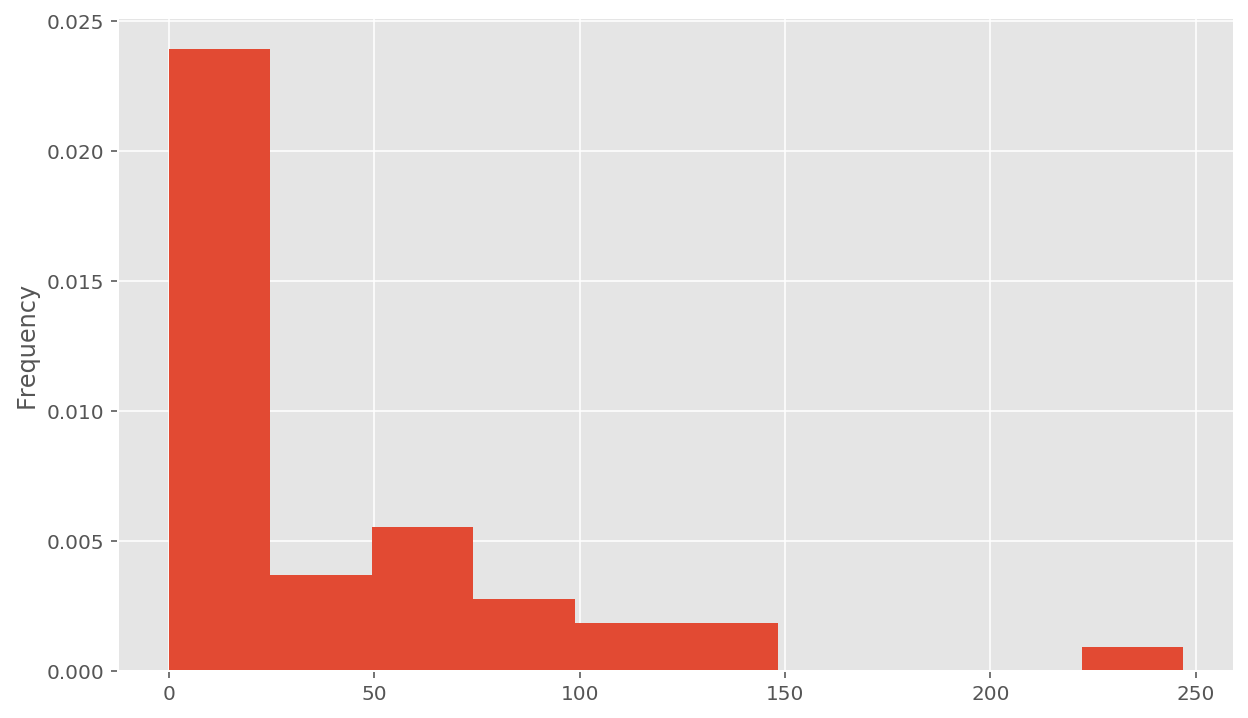

In [41]:
muestra2.beer_servings.plot(kind='hist', normed=True);

In [42]:
W, p = st.shapiro(muestra2.beer_servings)
print('Estadístico=%.3f, p-valor=%.3f' % (W, p))

Estadístico=0.745, p-valor=0.000


En este caso, las raciones de cerveza en la población de asia no se distribuyen según una normal, y por lo tanto __¡¡no podríamos haber hecho este test!!__. Habrá que utilizar __test no paramétricos__.

### Contrastes paramétricos para proporciones

**Suponemos** que la variable en estudio sigue una distribución
$X \sim\mathcal{B}e(p)$. Entonces el estadístico de contraste para el parámetro $p$ debe ser
    $d=\dfrac{(\overline{p}- p_0)\sqrt{n}}{\sqrt{p_0(1-p_0)}}$
    $$\begin{array}{|c|c|c|}
    \hline
      H_0 & H_1 & \mbox{Región crítica}  \\
      \hline\hline
      p = p_0 & p = p_1> p_0 & d \geq z_{1- \alpha}  \\
      \hline
      p = p_0 & p = p_1< p_0 & d \leq z_{\alpha}  \\
      \hline
      p = p_0 & p \neq p_0 & \mbox{$d \geq z_{1- \alpha/2}$ ó $d\leq z_{\alpha/2}$}  \\
      \hline
    \mbox{$p \leq p_0$ ó $p = p_0$}  & p > p_0 & d \geq z_{1- \alpha} \\
      \hline
    \mbox{$p \geq p_0$ ó $p = p_0$}  & p < p_0 & d \leq z_{\alpha} \\
      \hline
    \end{array}$$

**Suponemos** ahora que tenemos dos variables en estudio que siguen
distribuciones $X \sim \mathcal{B}e(p_1)$, $Y \sim\mathcal{B}e
(p_2)$ (independientes). Debe utilizarse el estadístico de contraste $d=
    \dfrac{\overline{p_1}-\overline{p_2}}{\sqrt{\overline{p}_{conj}(1-\overline
    {p}_{conj})\left(
    \frac{1}{n}+\frac{1}{m}\right)}}$,
    siendo $\overline{p}_{conj}=
    \dfrac{n\overline{p_1}+m\overline{p_2}}{n+m}$
    $$\begin{array}{|c|c|c|}
    \hline
      H_0 & H_1 & \mbox{Región crítica}  \\
      \hline\hline
       p_1 = p_2 & p_1 \neq p_2 & \mbox{$d \geq z_{1- \alpha/2}$ ó $d\leq z_{\alpha/2}$}  \\
      \hline
    \mbox{$p_1 \leq p_2$ ó $p_1 = p_2$}  & p_1 > p_2 & d \geq z_{1- \alpha} \\
      \hline
    \mbox{$p_1 \geq p_2$ ó $p_1 = p_2$}  & p_1 < p_2 & d \leq z_{\alpha} \\
      \hline
    \end{array}$$

**[Ejercicio]** Crear una función capaz de calcular un contraste para la diferencia de proporciones. 

# Relación <span style="color:green"> Numérica x Numérica </span>

En esta sección nos planteamos si dos variables cuantitativas están relacionas y de qué manera, para ello vamos a generar datos sintéticos y analizar sus propiedades. 

El modelo de regresión simple utiliza una única variable predictora/independiente/explicativa para intentar explicar otra variable dependiente/explicada. El modelo de regresión lineal puede escribirse como:

$$y_i = \alpha + \beta \cdot x_i + \epsilon_i, $$


donde:

* $y$ = variable dependiente

* $\beta$ = coeficiente de regresión (pendiente de la recta)

* $\alpha$ = constante (ordenada en el origen)

* $x$ =variable predictora (o independiente)

* $\epsilon$ = término de error, el cual recoge la variabilidad/incertidumbre que no puede explicarse.


In [8]:
alpha = 5.
beta = 3.
Npuntos = 100
epsilon = st.norm(loc=0., scale=1.)

x = np.linspace(-5, 5, Npuntos)
y_verdadera = alpha + beta*x
y_observada = alpha + beta*x + epsilon.rvs(Npuntos)


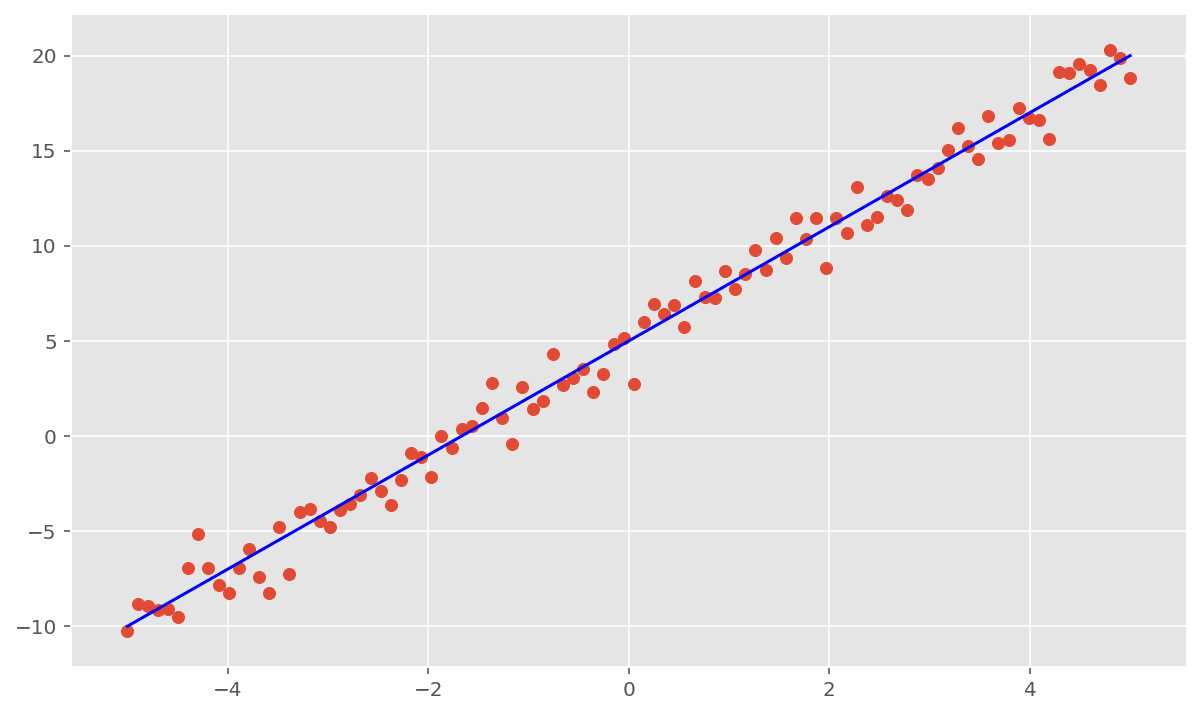

In [9]:
plt.plot(x,y_verdadera, color = 'blue')
plt.scatter(x,y_observada);

Vamos a comprobar que los datos tienen relación lineal. Esto se realiza mediante la covarianza y/o la correlación de Pearson. La correlación no se ve afectada por las unidades de la variable y será preferible elegirla en lugar de la covarianza.

In [10]:
df = pd.DataFrame({'x':x, 'y':y_observada})

df['x'].cov(df['y'])

25.82887355505669

In [12]:
df['x'].corr(df['y'], method='spearman')

0.994107410741074

La correlación nos da una medida de asociación lineal (tipo y fortaleza). Cuanto más cercana a 1 o -1, más fuerte es la relación lineal:



 <figure>
  <img src="https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg" width="756" height="512">
</figure> 

In [13]:
#import statsmodels.formula.api as smf

from statsmodels.formula.api import ols
model = ols(formula='y ~ x', data=df).fit()

In [14]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     8067.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.21e-96
Time:                        17:02:38   Log-Likelihood:                -138.50
No. Observations:                 100   AIC:                             281.0
Df Residuals:                      98   BIC:                             286.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9386      0.098     50.578      0.0

Apartir del resumen del modelo ajustado podemos ver los valores de $a$ y $b$ estimados para nuestros datos (recordemos que los valores verdaderos son $\alpha = 5$ y $\beta=3$

In [15]:
model.params

Intercept    4.938614
x            3.007708
dtype: float64

Además el valor del coeficiente de determinación ($R^2$) es

In [16]:
model.rsquared

0.9879970694217616

lo que significa que hay un porcentaje muy alto de variabilidad de $Y$ explicada por el modelo. En general, se dice que un modelo no es adecuado (no podemos fiarnos de sus predicciones) si $R^2 < 0.75$, pero esto puede cambiar según el estudio que estemos realizando. La predicción para el valor $x=1.5$ es

In [17]:
model.predict(model.params, 1.5)

0    13.984924
dtype: float64

# Ampliación 1. El cuarteto de Anscombe

In [28]:
import seaborn as sns

ans = sns.load_dataset("anscombe")

print(ans.info())
print(ans.groupby(['dataset']).describe())
print(ans.groupby(['dataset']).corr())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dataset  44 non-null     object 
 1   x        44 non-null     float64
 2   y        44 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.2+ KB
None
            x                                               y            \
        count mean       std  min  25%  50%   75%   max count      mean   
dataset                                                                   
I        11.0  9.0  3.316625  4.0  6.5  9.0  11.5  14.0  11.0  7.500909   
II       11.0  9.0  3.316625  4.0  6.5  9.0  11.5  14.0  11.0  7.500909   
III      11.0  9.0  3.316625  4.0  6.5  9.0  11.5  14.0  11.0  7.500000   
IV       11.0  9.0  3.316625  8.0  8.0  8.0   8.0  19.0  11.0  7.500909   

                                                   
              std   min    25%   50%   75%    max  
dataset              

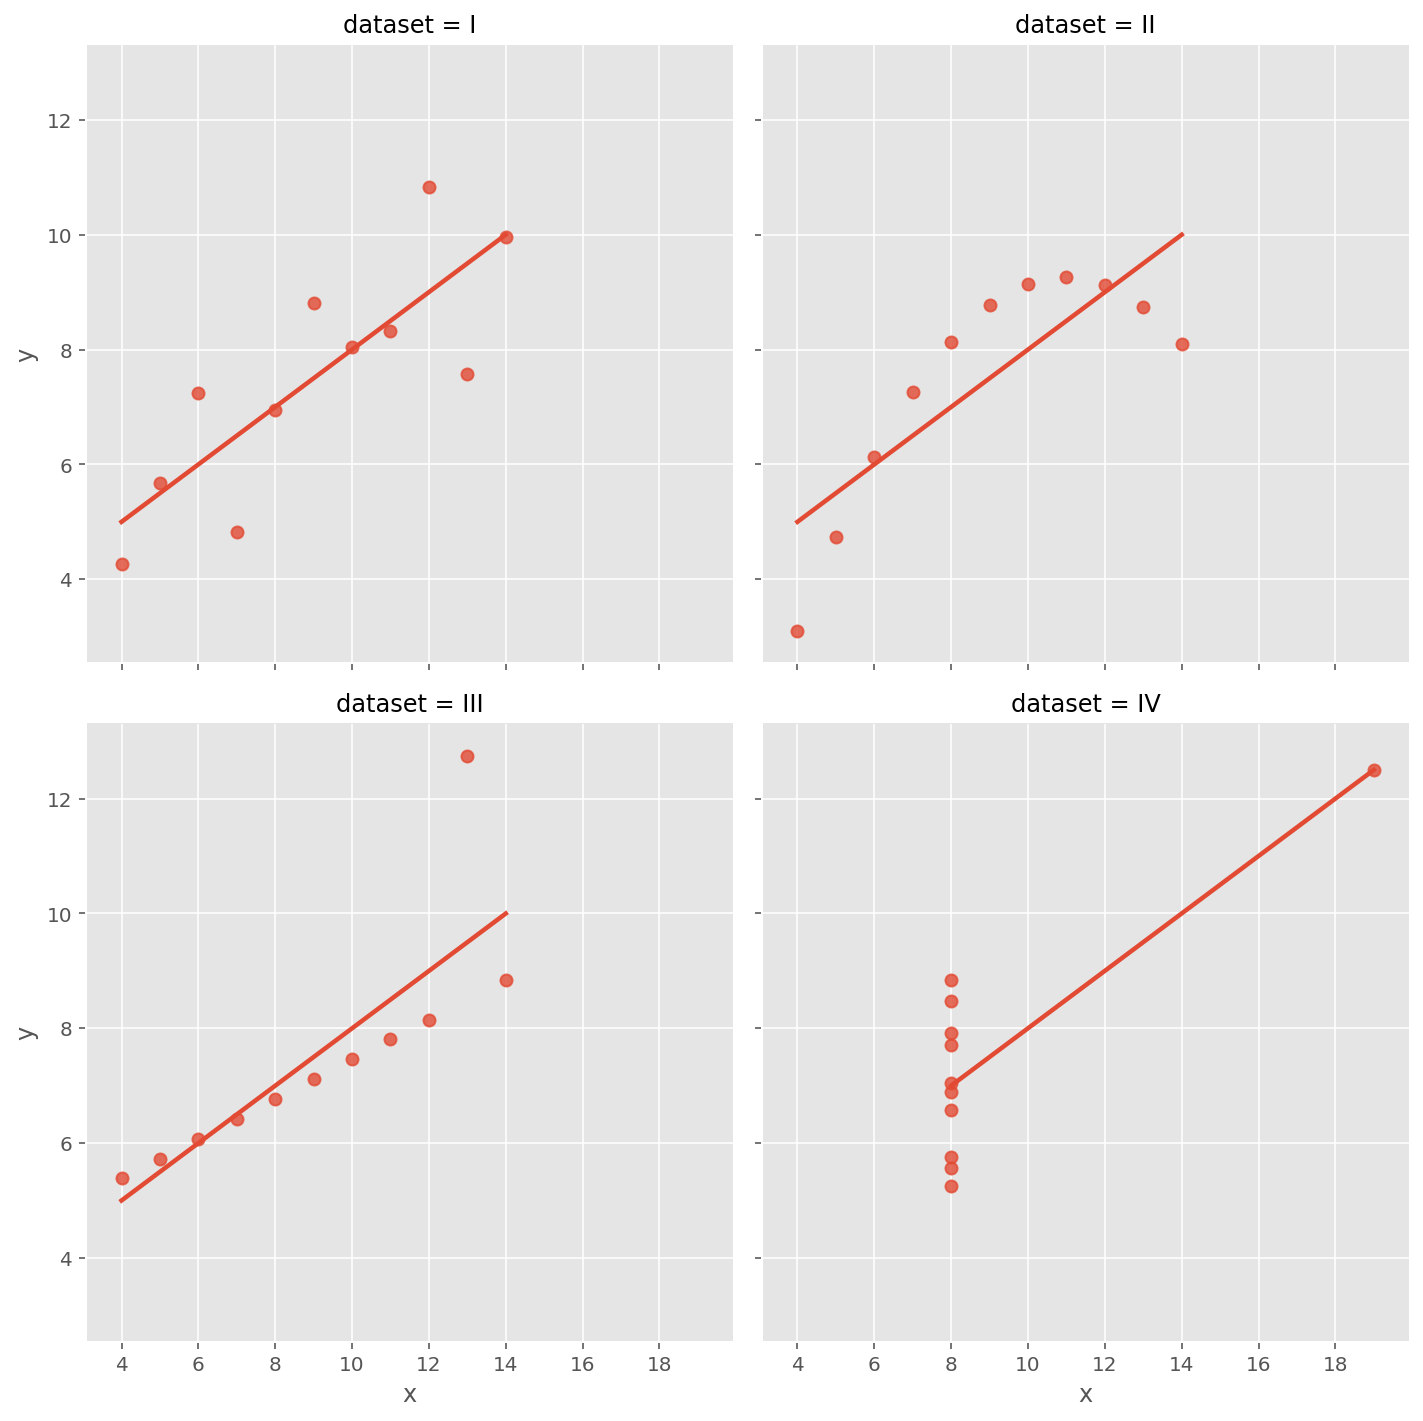

In [29]:
sns.lmplot(x="x", y="y", col="dataset", data=ans, col_wrap=2, height=5, ci=0);

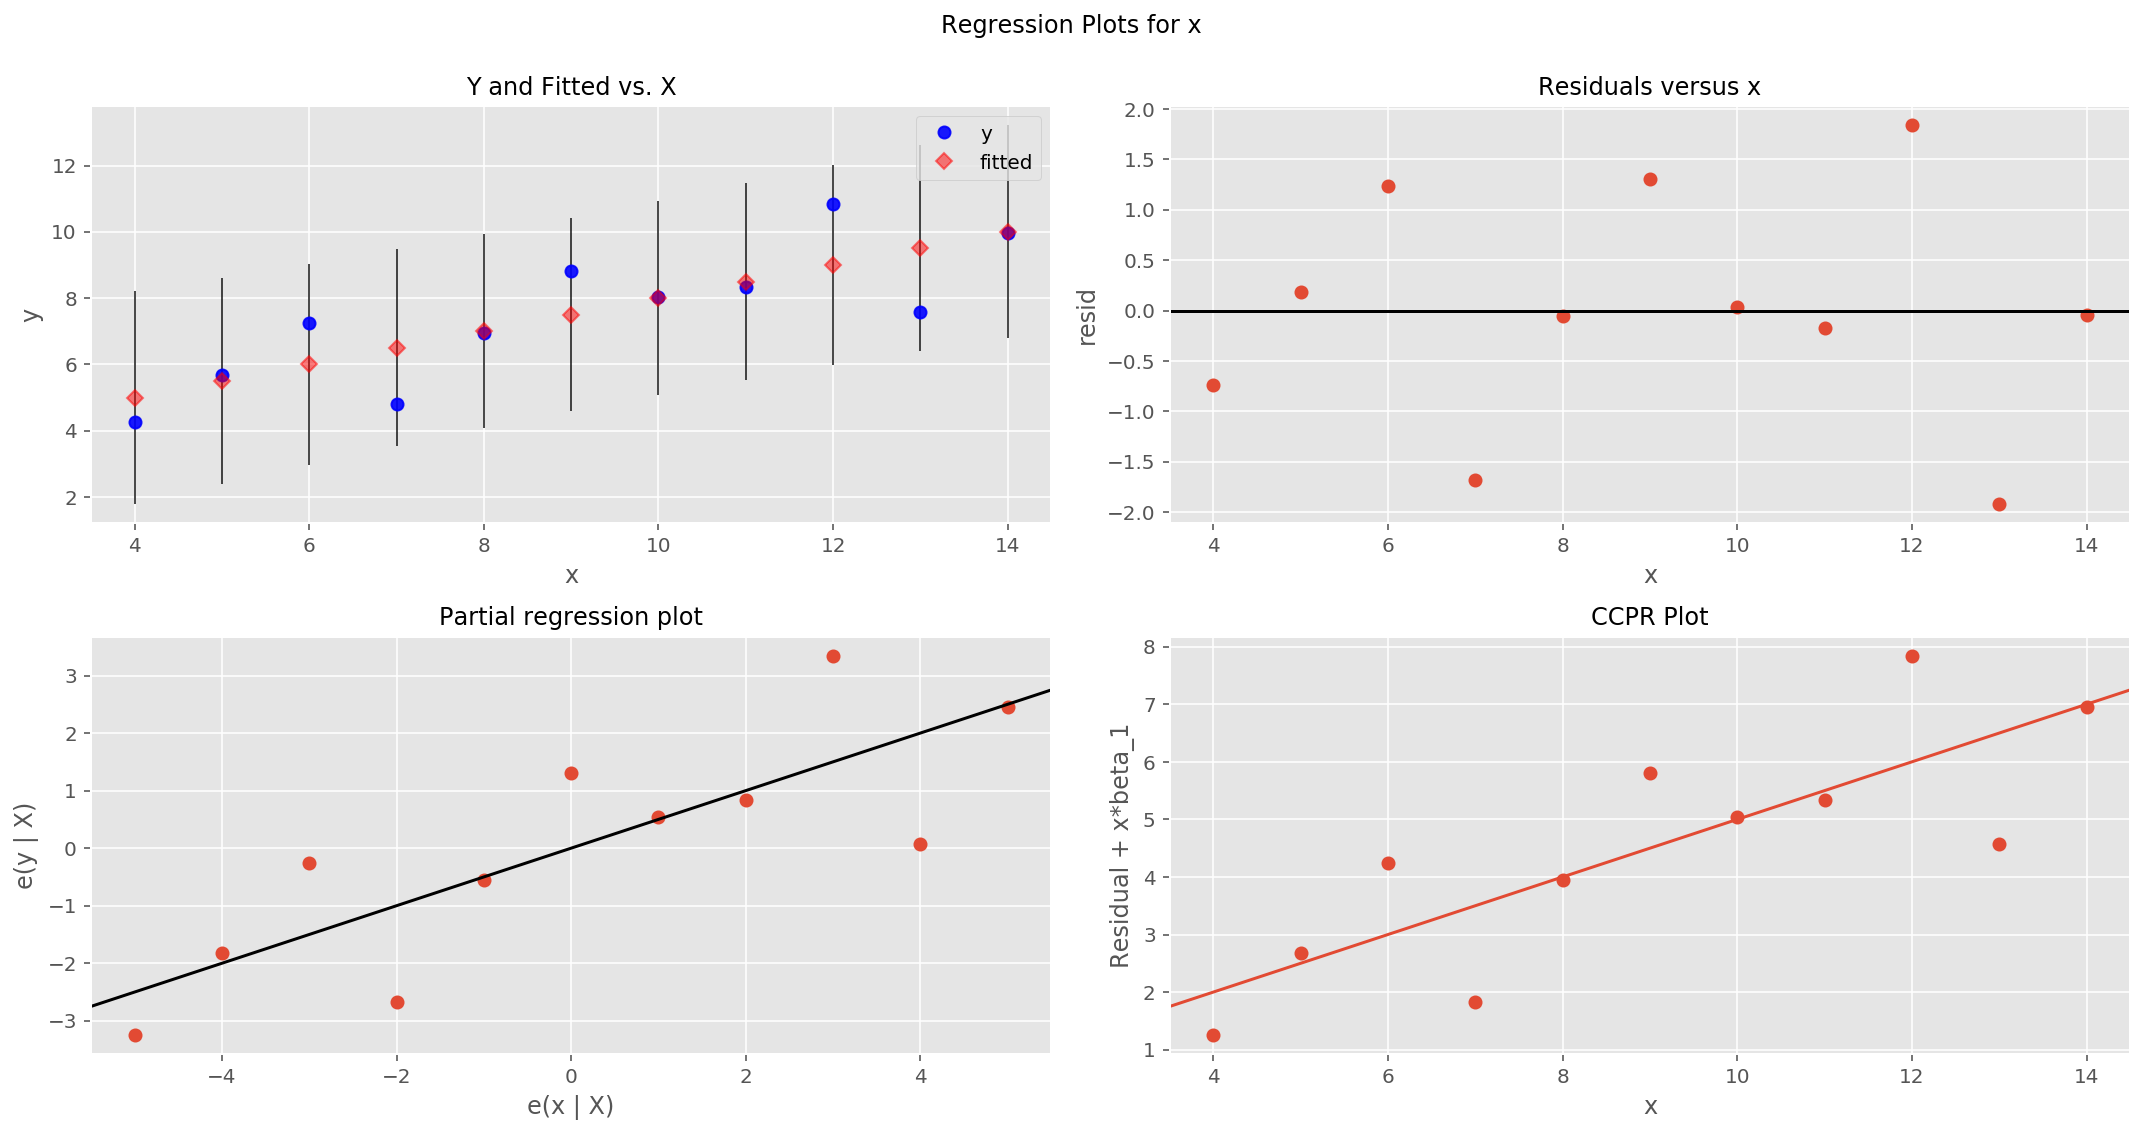

In [30]:
ansI = ans.loc[ans.dataset == 'I']
modelI = ols('y ~ x', data=ansI).fit()
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(modelI, 'x', fig = fig)

## Diagnóstico del modelo I
***

Pueden encontrase más detalles y contrastes en http://www.statsmodels.org/stable/diagnostic.html

### Hipótesis 1: Estamos modelando la regresión de manera correcta con un modelo lineal

La hipótesis nula es que la regresión está modelada correctamente con un modelo lineal: la variable X y la MEDIA de Y están sobre una recta: E(Y|X)

In [31]:
from statsmodels.stats.diagnostic import linear_harvey_collier
linear_harvey_collier(modelI)

Ttest_1sampResult(statistic=0.4292664614553593, pvalue=0.6806318987913486)

### Hipótesis 2: Los residuos son independientes 

Testeamos la presencia de autocorrelación en los residuos. Los valores obtenidos están entre 0 y 4. Si sale 2 entonces no hay autocorrelación. Si está cerca de 0 hay presencia de autocorrelación positiva; cerca de 4 autocorrelación negativa.

In [32]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(modelI.resid)

3.2122899593630634

¿Quién ha diseñado el estudio? ¿Por qué no se han cogido los datos de manera independiente?

### Hipótesis 3: Normalidad de los residuos

In [33]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(modelI.resid)
lzip(name, test)

[('Jarque-Bera', 0.2894334782733337),
 ('Chi^2 two-tail prob.', 0.8652673547788415),
 ('Skew', -0.12215570480195045),
 ('Kurtosis', 2.2438233272171164)]

### Hipótesis 4: Las varianzas de los residuos son iguales (homocedasticidad)

Realiza un test para comprobar que la varianza resitudal no depende de la variable X

In [34]:
from statsmodels.stats.diagnostic import het_breuschpagan
name = ['Lagrange', 'Lagr. p-value', 'F Statistic', 'F.Stat p-value']
test = het_breuschpagan(modelI.resid,modelI.model.exog)

# lagrange multiplier statistic, p-value of lagrange multiplier test,
# f-statistic of the hypothesis that the error variance does not depend on x, 
# p-value for the f-statistic
# 
# https://en.wikipedia.org/wiki/Breusch%E2%80%93Pagan_test

lzip(name, test)

[('Lagrange', 0.6553075561484129),
 ('Lagr. p-value', 0.41822145680189393),
 ('F Statistic', 0.5701250218261523),
 ('F.Stat p-value', 0.4695065830349903)]

### Antes de seguir ... ¿hay datos que estén influenciando la regresión?


* Dato atípico (outlier): una observación con un residuo muy grande, es decir, se separa mucho de la nuebe de puntos.
* Puntos de apalancamiento: puntos con un valor $x$ muy lejano a la media de $X$.
* Observaciones de influencia: observaciones que hacen variar la pendiente de la línea de regresión.



### Test de influencia para detectar datos atípicos

/home/angel/anaconda3/envs/modulo2/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


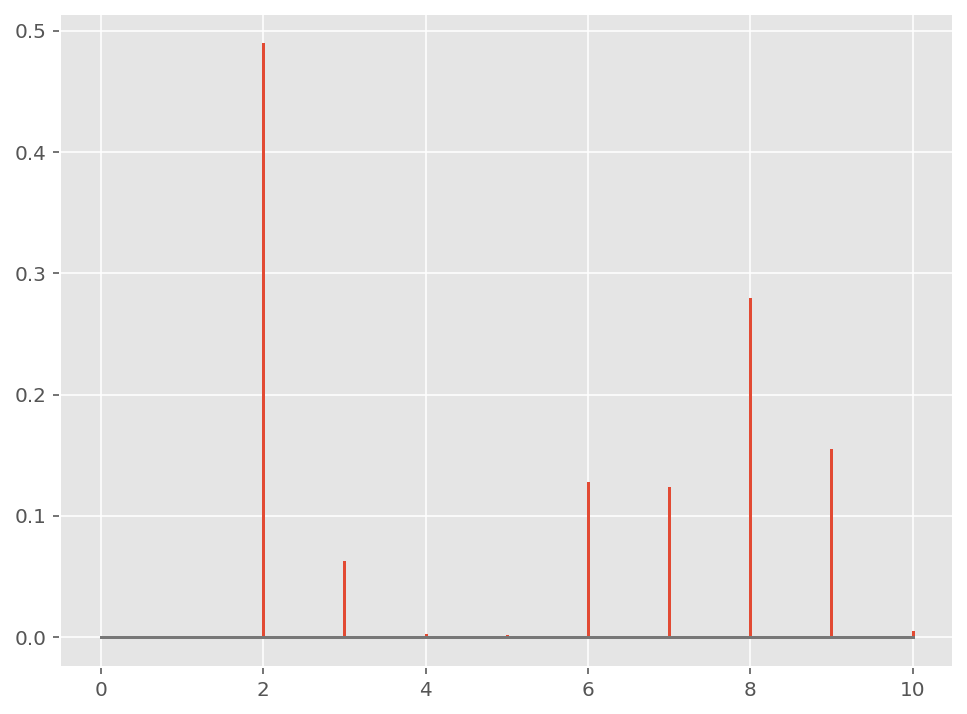

In [35]:
from statsmodels.stats.outliers_influence import OLSInfluence

test_class = OLSInfluence(modelI)
c, p = test_class.cooks_distance

fig, ax = plt.subplots(figsize=(8,6))
fig = plt.stem(np.arange(len(c)), c, markerfmt=",")

También podemos pintar los residos normalizados al cuadrado contra el apalancamiento (Leverage) 

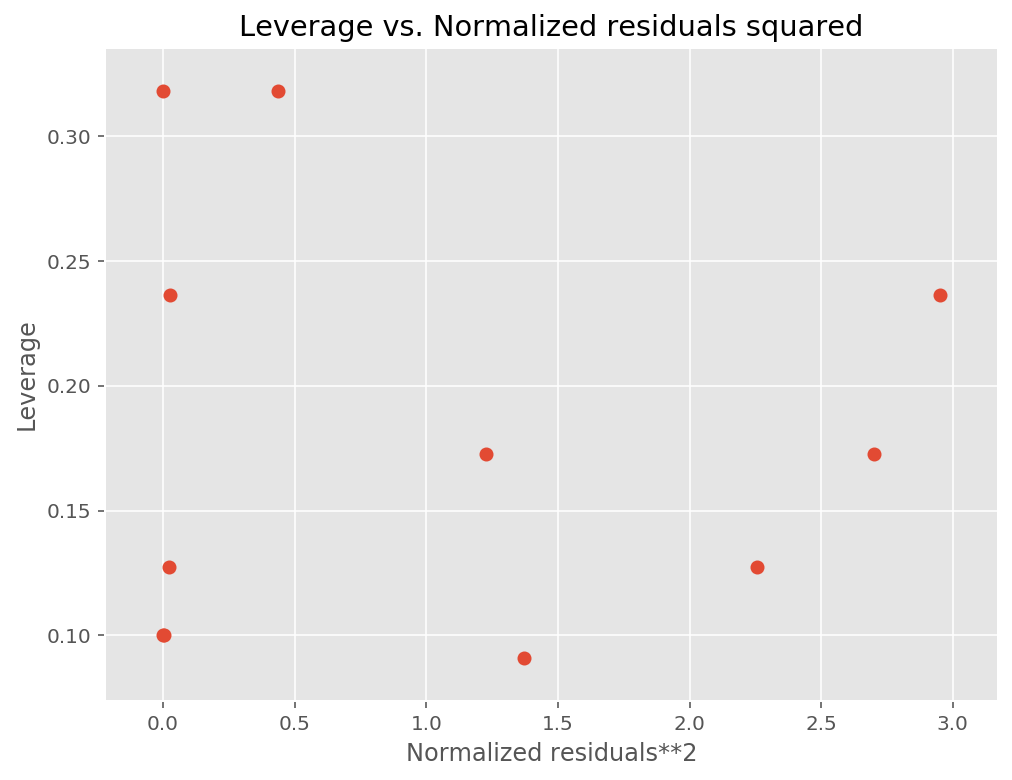

In [36]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(modelI, ax = ax)

### Gráfico de influencia
La distancia de Cook es una buena medida para detectar si alguno de los valores está teniedo influencia en la recta de regresión.


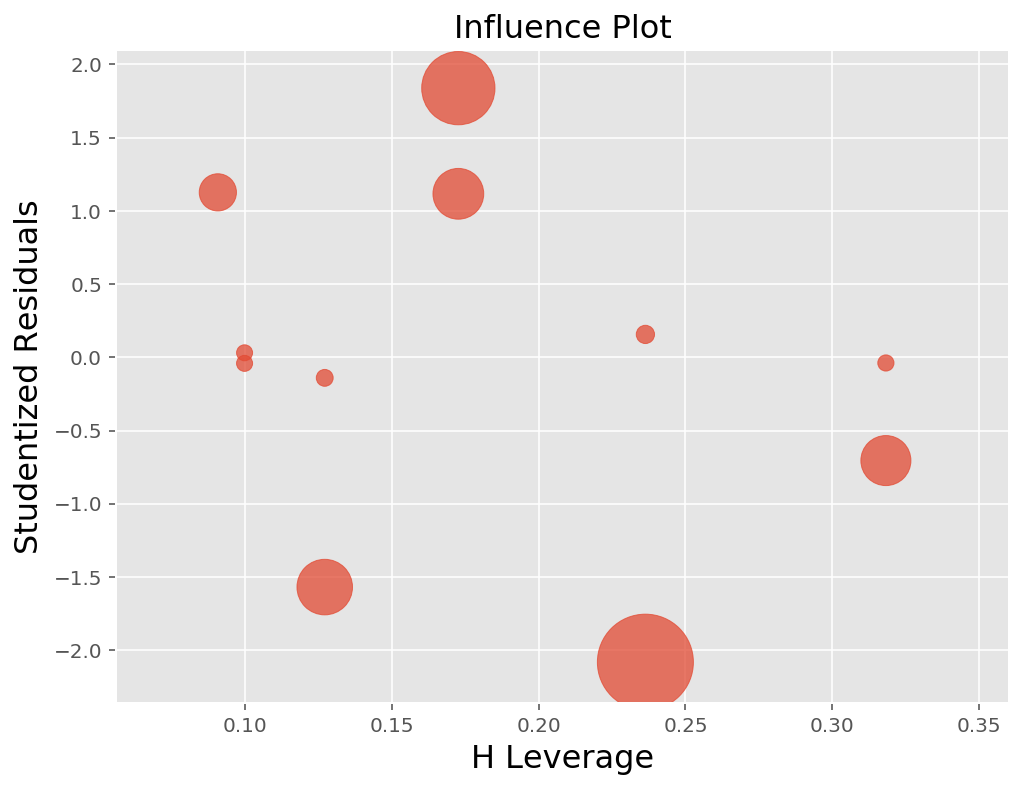

In [37]:
from statsmodels.graphics.regressionplots import influence_plot
fig, ax = plt.subplots(figsize=(8,6))
fig = influence_plot(modelI, ax = ax, criterion="cooks")

## ¡Ahora sí podemos ver un resumen de los resultados!

In [24]:
print(modelI.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):            0.00217
Time:                        17:47:53   Log-Likelihood:                -16.841
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0001      1.125      2.667      0.0

/home/angel/anaconda3/envs/modulo2/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


## Diagnóstico del modelo Modelo II
***

#### Comprobamos las hipótesis

In [25]:
ansII = ans.loc[ans.dataset == 'II']
modelII = ols('y ~ x', data=ansII).fit()

# ¿Es un modelo lineal?
print(linear_harvey_collier(modelII))

NameError: name 'linear_harvey_collier' is not defined

In [ ]:
# ¿Los residuos siguen una distribución normal?
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(modelII.resid)
lzip(name, test)

In [26]:
# ¿Homocedasticidad de residuos?
name = ['Lagrange', 'Lagr. p-value', 'F Statistic', 'F.Stat p-value']
test = het_breuschpagan(modelII.resid,modelII.model.exog)
lzip(name, test)

NameError: name 'het_breuschpagan' is not defined

In [58]:
# ¿Hay autocorrelación de residuos? ¿Son independientes?
durbin_watson(modelII.resid)

2.1875699488977105

#### Obtenemos el resumen de los resultados

In [59]:
print(modelII.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Thu, 21 Mar 2019   Prob (F-statistic):            0.00218
Time:                        19:31:27   Log-Likelihood:                -16.846
No. Observations:                  11   AIC:                             37.69
Df Residuals:                       9   BIC:                             38.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0009      1.125      2.667      0.0

/home/angel/anaconda3/envs/ceura/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


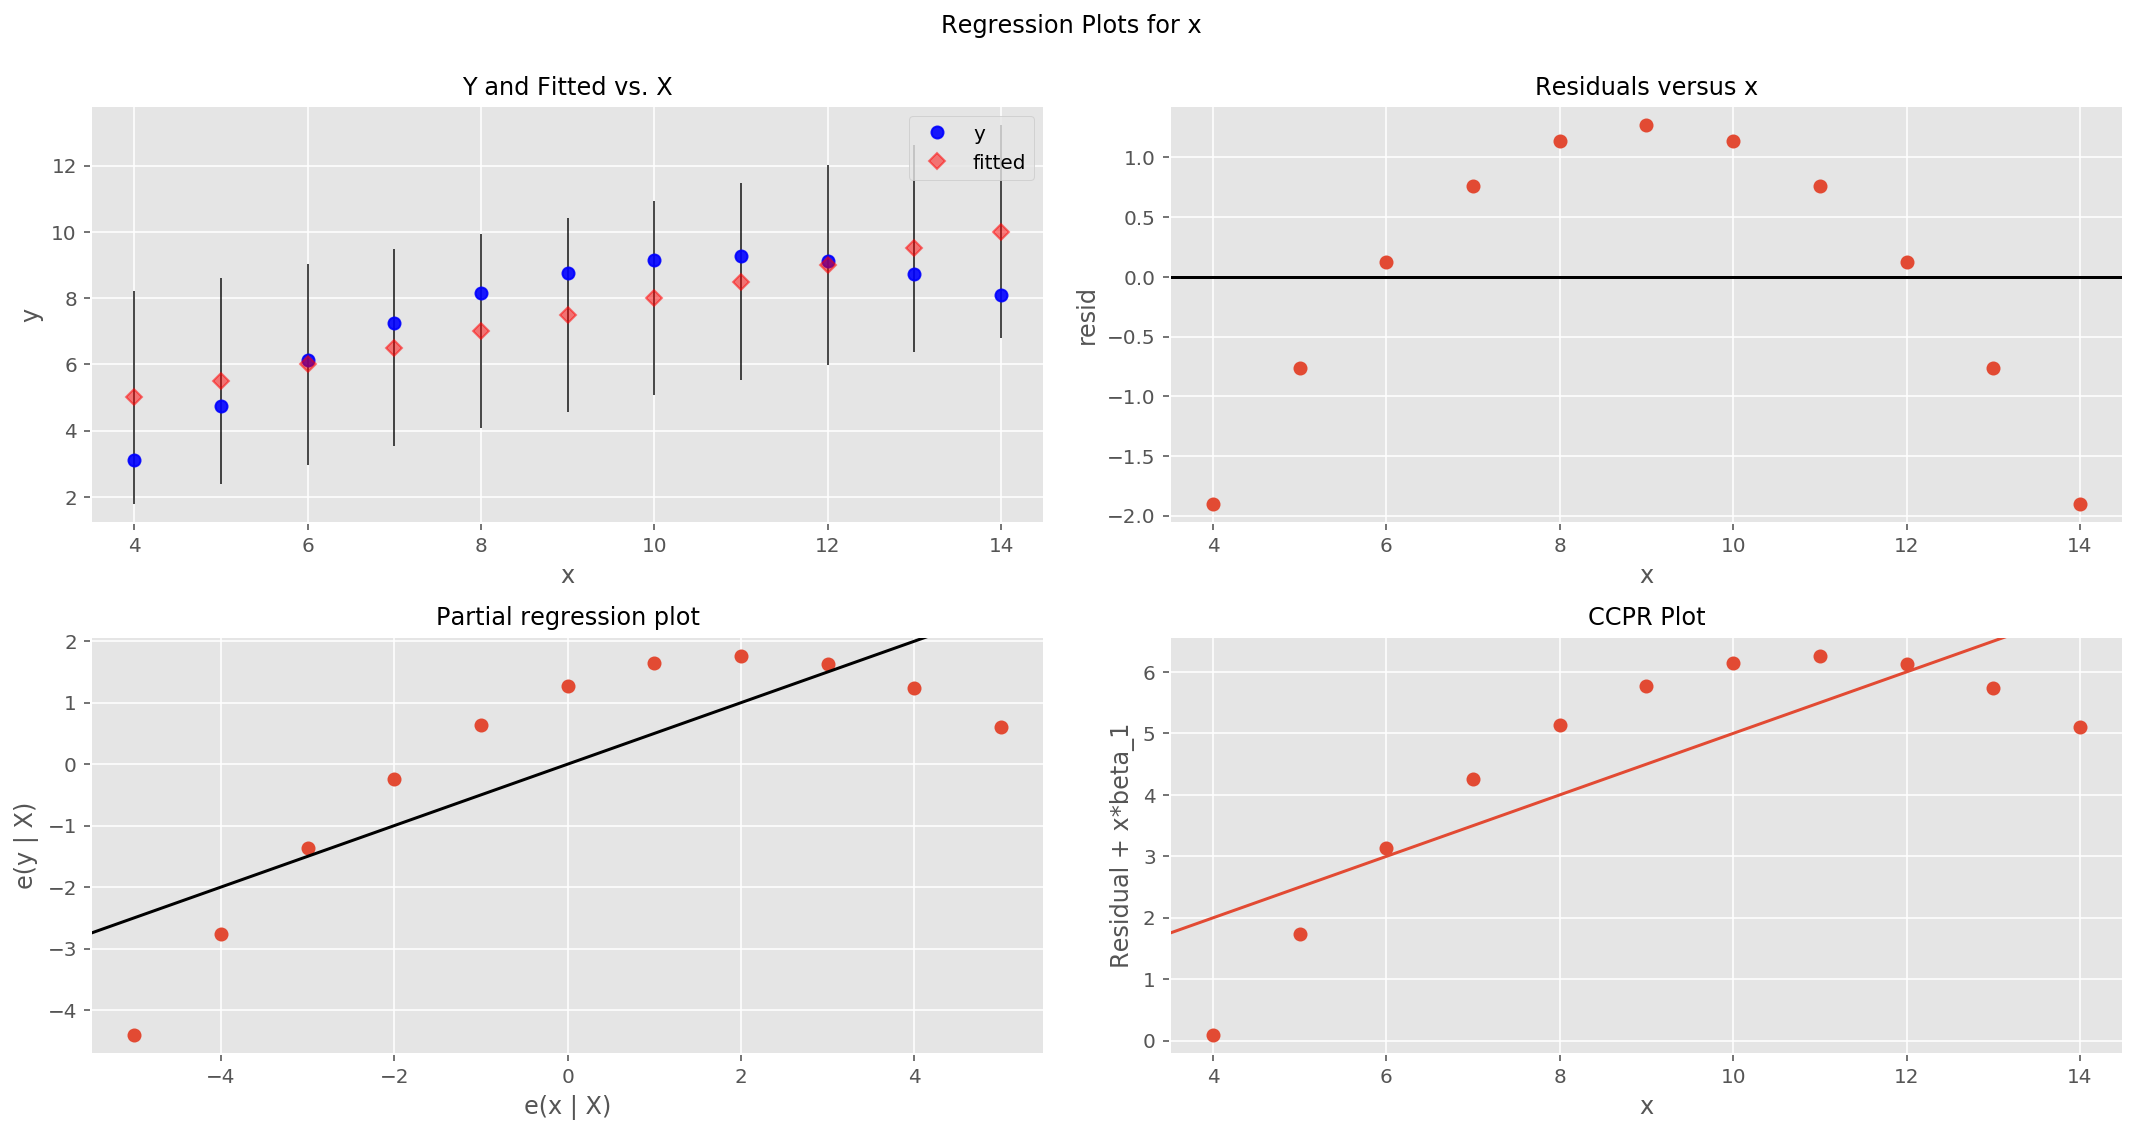

In [60]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(modelII, 'x', fig = fig)

#### ¿Mejor un modelo cuadrático?

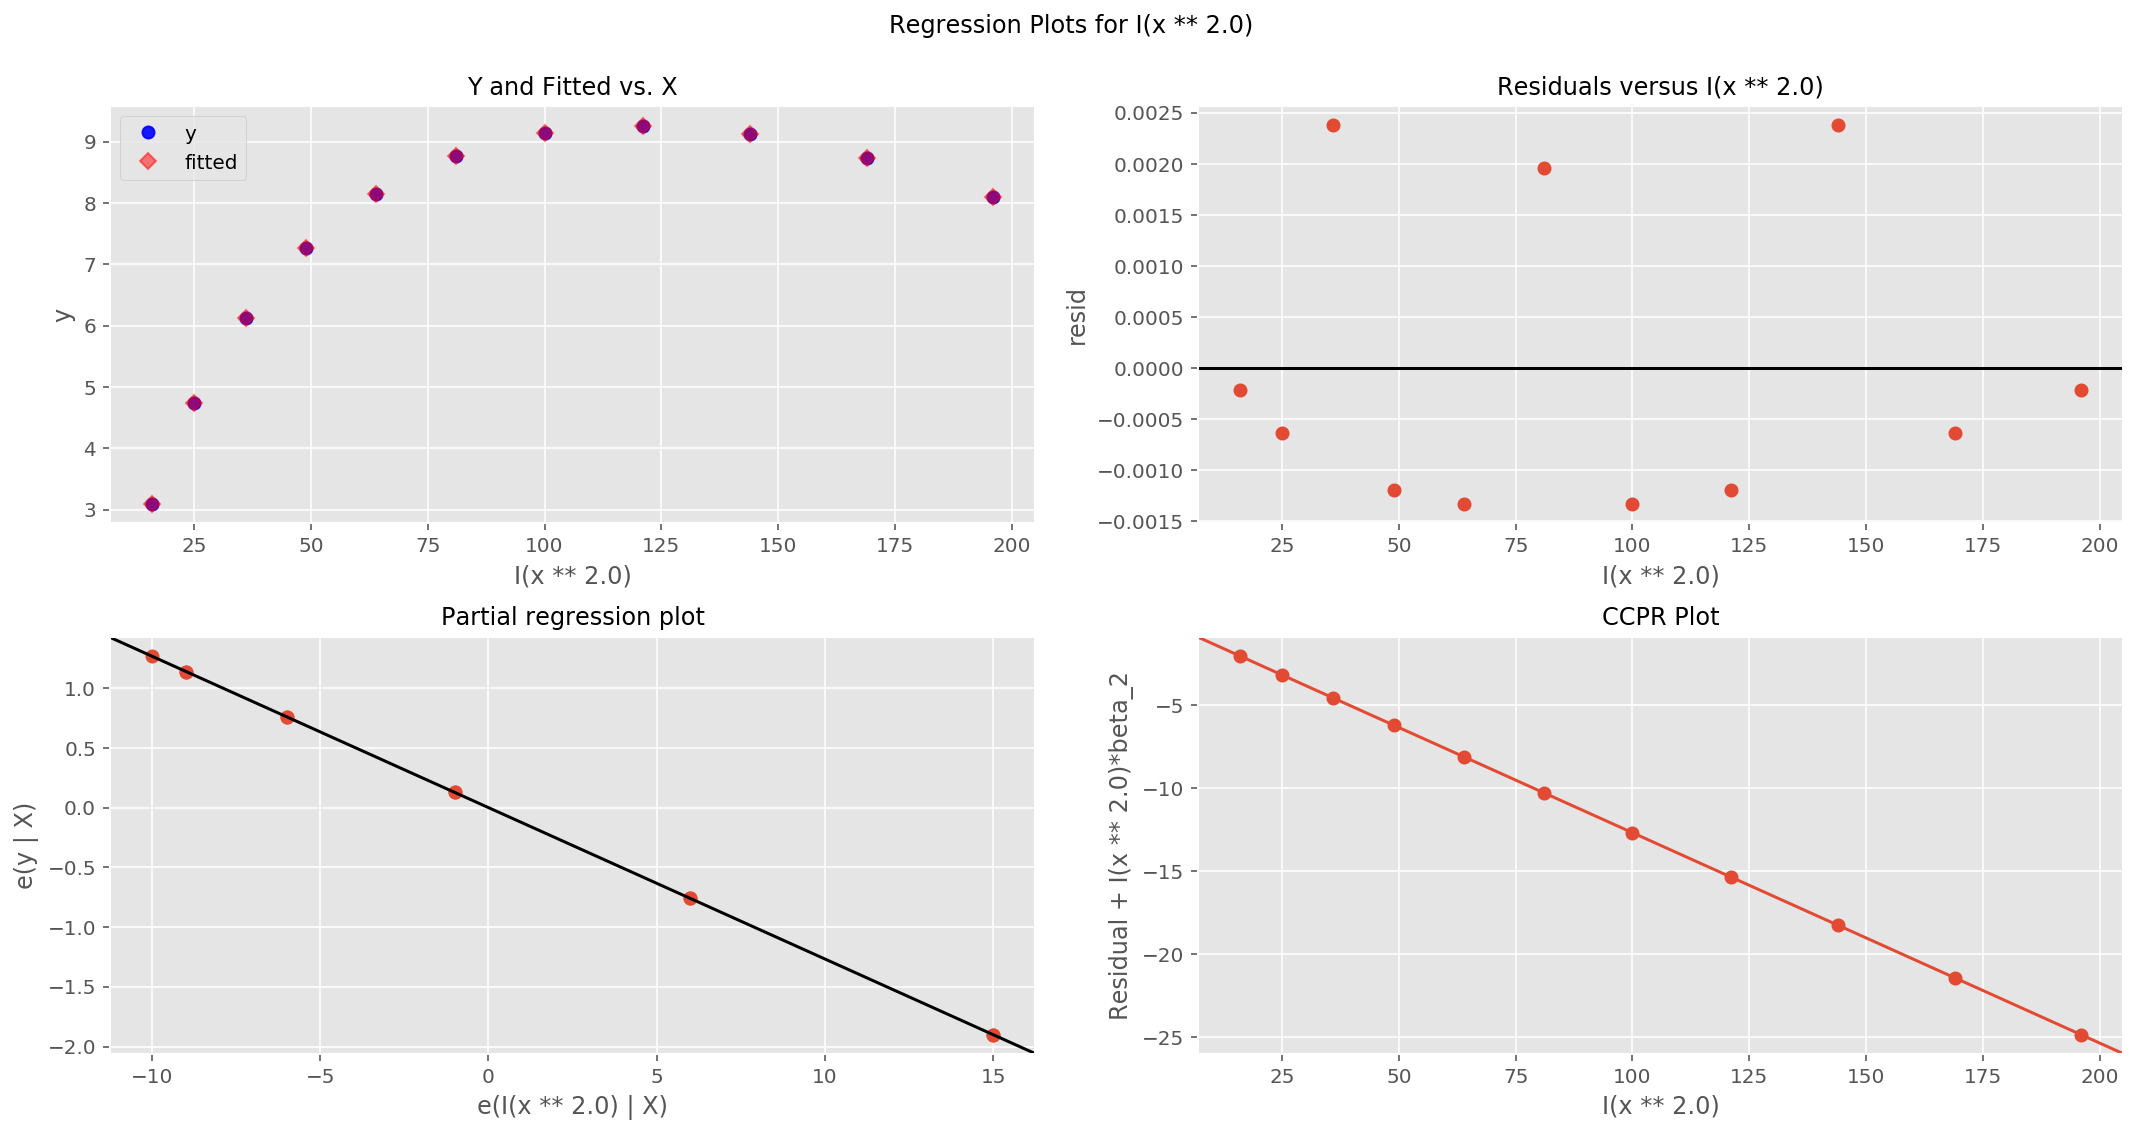

In [61]:
modelII = ols('y ~  1 + x + I(x**2.0)', data=ansII).fit()
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(modelII, 'I(x ** 2.0)', fig = fig)

In [62]:
print(modelII.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.378e+06
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           8.64e-26
Time:                        19:31:30   Log-Likelihood:                 56.471
No. Observations:                  11   AIC:                            -106.9
Df Residuals:                       8   BIC:                            -105.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.9957      0.004  -1384.713      

/home/angel/anaconda3/envs/ceura/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


## Diagnóstico para el modelo III
***

In [63]:
ansIII = ans.loc[ans.dataset == 'III']
modelIII = ols('y ~ x', data=ansIII).fit()
print(modelIII.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     17.97
Date:                Thu, 21 Mar 2019   Prob (F-statistic):            0.00218
Time:                        19:31:31   Log-Likelihood:                -16.838
No. Observations:                  11   AIC:                             37.68
Df Residuals:                       9   BIC:                             38.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0025      1.124      2.670      0.0

/home/angel/anaconda3/envs/ceura/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


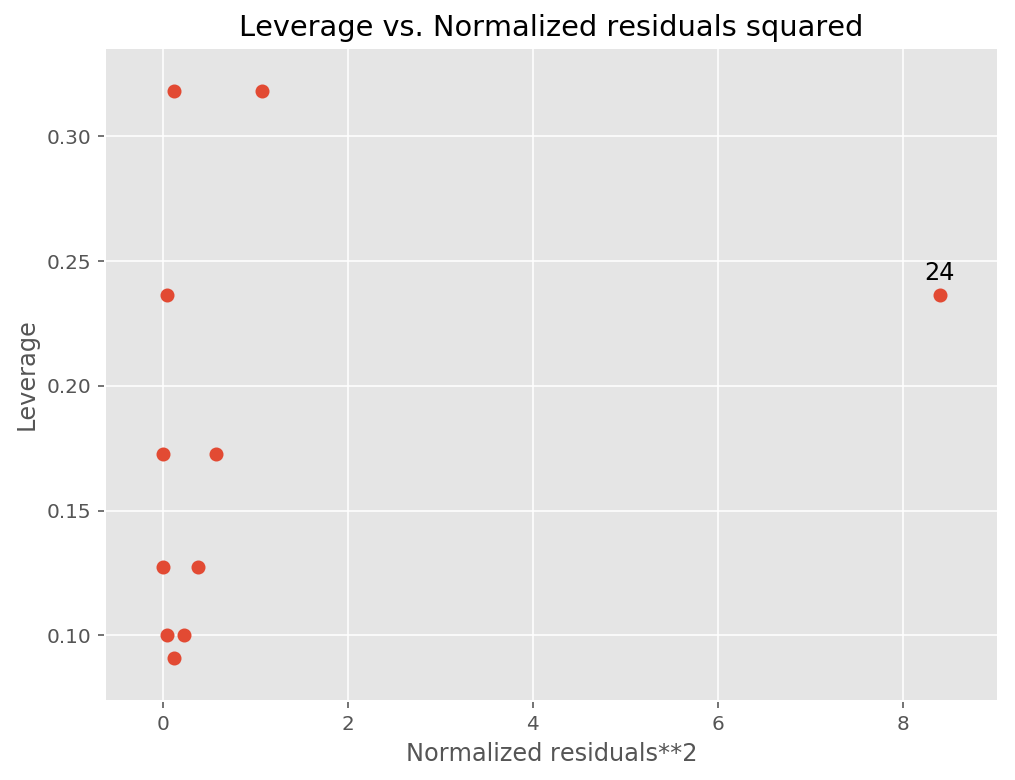

In [64]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(modelIII, ax = ax)

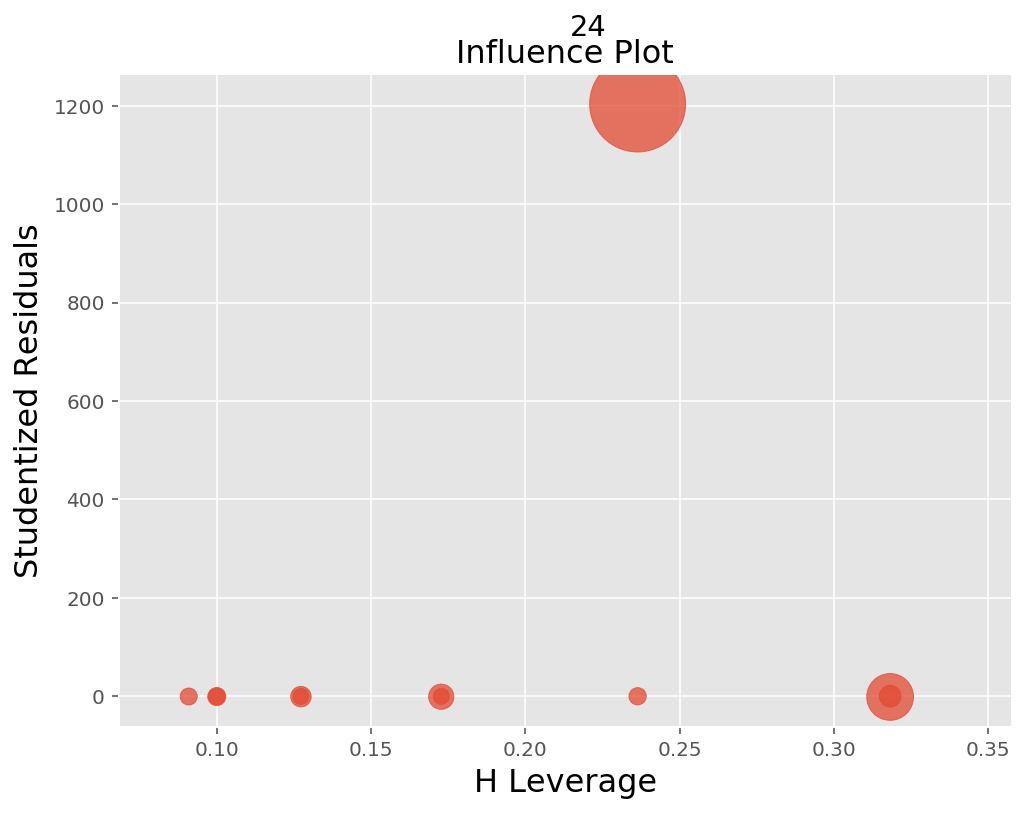

In [65]:
fig, ax = plt.subplots(figsize=(8,6))
fig = influence_plot(modelIII, ax = ax)

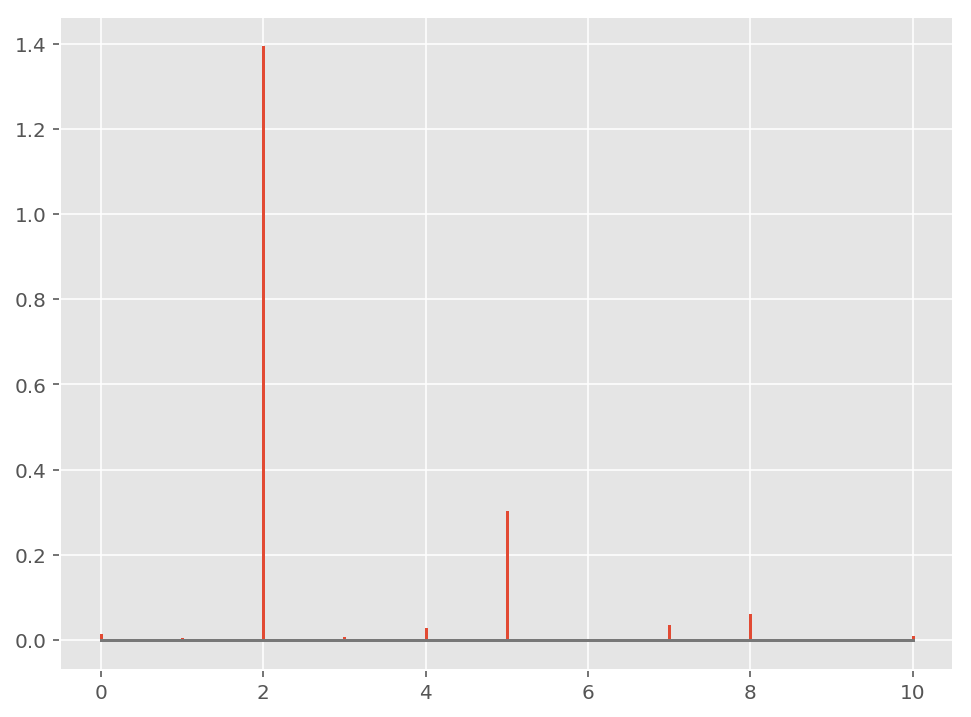

In [66]:
influence = modelIII.get_influence()
#c is the distance and p is p-value
(c, p) = influence.cooks_distance
fig, ax = plt.subplots(figsize=(8,6))
fig = plt.stem(np.arange(len(c)), c, markerfmt=",")

In [67]:
import statsmodels.api as sm

### Example for using Huber's T norm with the default
### median absolute deviation scaling

#data = sm.datasets.stackloss.load()
#data.y = sm.add_constant(data.y)
huber_t = sm.RLM(ansIII.y, ansIII.x, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.summary())
#data.names
#modelIII.resid.

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   11
Model:                            RLM   Df Residuals:                       10
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 21 Mar 2019                                         
Time:                        19:31:34                                         
No. Iterations:                     2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.7967      0.050     16.053      0.0

# Ampliación 2. Ejemplo con datos reales

In [68]:
housing_price_index = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/monthly-hpi.csv')
unemployment = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/unemployment-macro.csv')

In [69]:
df = housing_price_index.merge(unemployment, on='date')

In [70]:
df.head()

,date,housing_price_index,total_unemployed,more_than_15_weeks,not_in_labor_searched_for_work,multi_jobs,leavers,losers
0,2010-11-01,186.07,16.9,8696,2531,6708,5.7,63.0
1,2010-12-01,183.27,16.6,8549,2609,6899,6.4,61.2
2,2011-01-01,181.35,16.2,8393,2800,6816,6.5,60.1
3,2011-02-01,179.66,16.0,8175,2730,6741,6.4,60.2
4,2011-03-01,178.84,15.9,8166,2434,6735,6.4,60.3


Calculamos una medida de asociación para las variables _índice de precios_ y _total de desempleados_: covarianza y correlación de Pearson:

In [71]:
df['housing_price_index'].cov(df['total_unemployed'])

-45.621300799086754

In [72]:
df['housing_price_index'].corr(df['total_unemployed'], method='pearson')

#pearson : standard correlation coefficient
#kendall : Kendall Tau correlation coefficient
#spearman : Spearman rank correlation

-0.9719223250192387

In [73]:
housing_model = ols("housing_price_index ~ total_unemployed", data=df).fit()

# Otra manera. Hay que incluir la constante en el modelo
# df['constant'] = np.ones(( len(df), ))
# X = df[['total_unemployed','constant']][:-1]
# Y = df.housing_price_index[:-1]
# housing_model = sm.OLS(Y,X).fit()

In [74]:
print(housing_model.summary())

                             OLS Regression Results                            
Dep. Variable:     housing_price_index   R-squared:                       0.945
Model:                             OLS   Adj. R-squared:                  0.944
Method:                  Least Squares   F-statistic:                     1211.
Date:                 Thu, 21 Mar 2019   Prob (F-statistic):           2.36e-46
Time:                         19:31:42   Log-Likelihood:                -216.53
No. Observations:                   73   AIC:                             437.1
Df Residuals:                       71   BIC:                             441.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          314.3908   

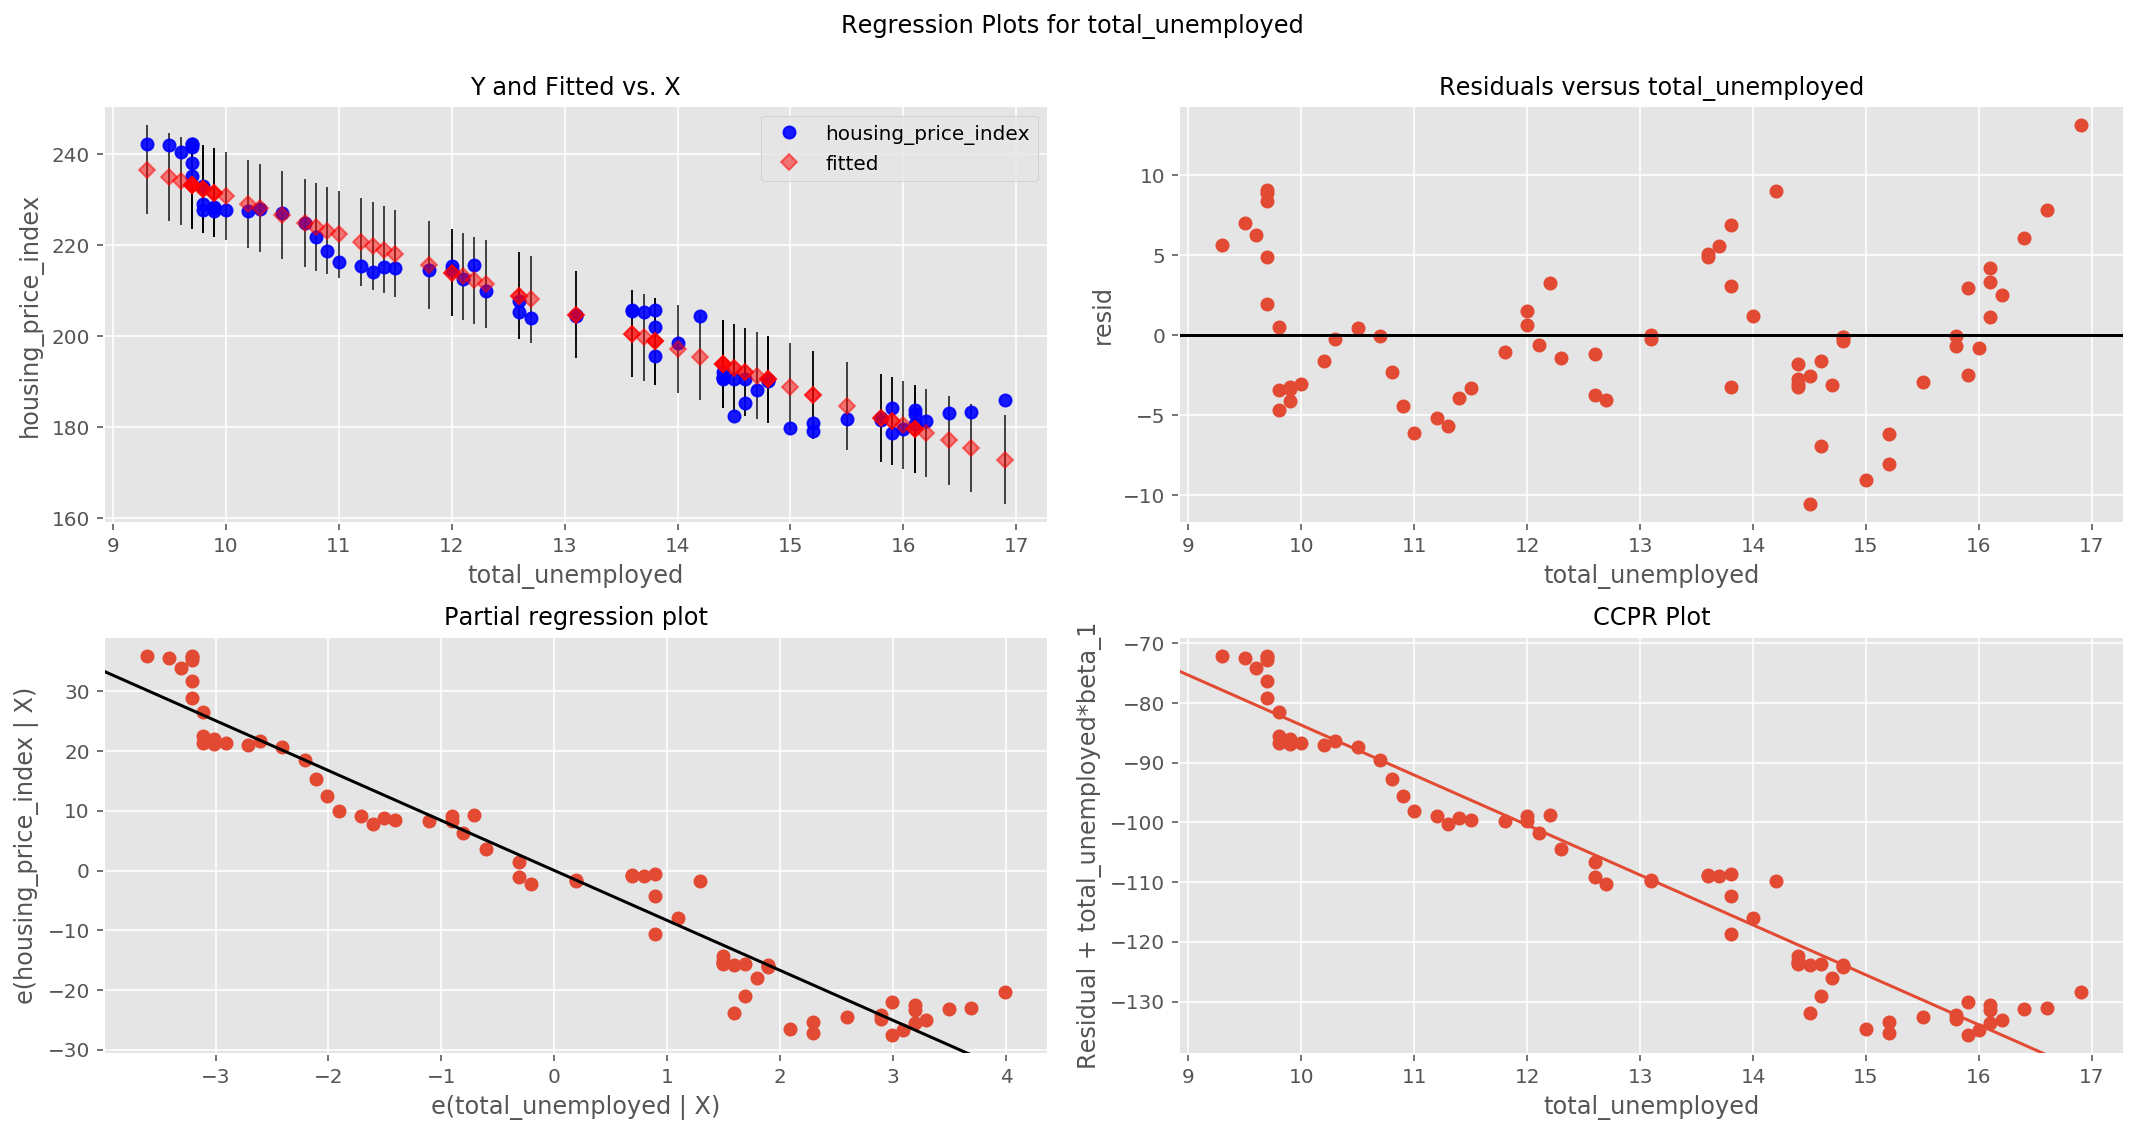

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt

# use figsize to adjust size, and pass in to plot_regress_exog
fig = plt.figure(figsize=(15,8))

# pass in the model as the first parameter, then specify the 
# predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(housing_model, "total_unemployed", fig=fig)

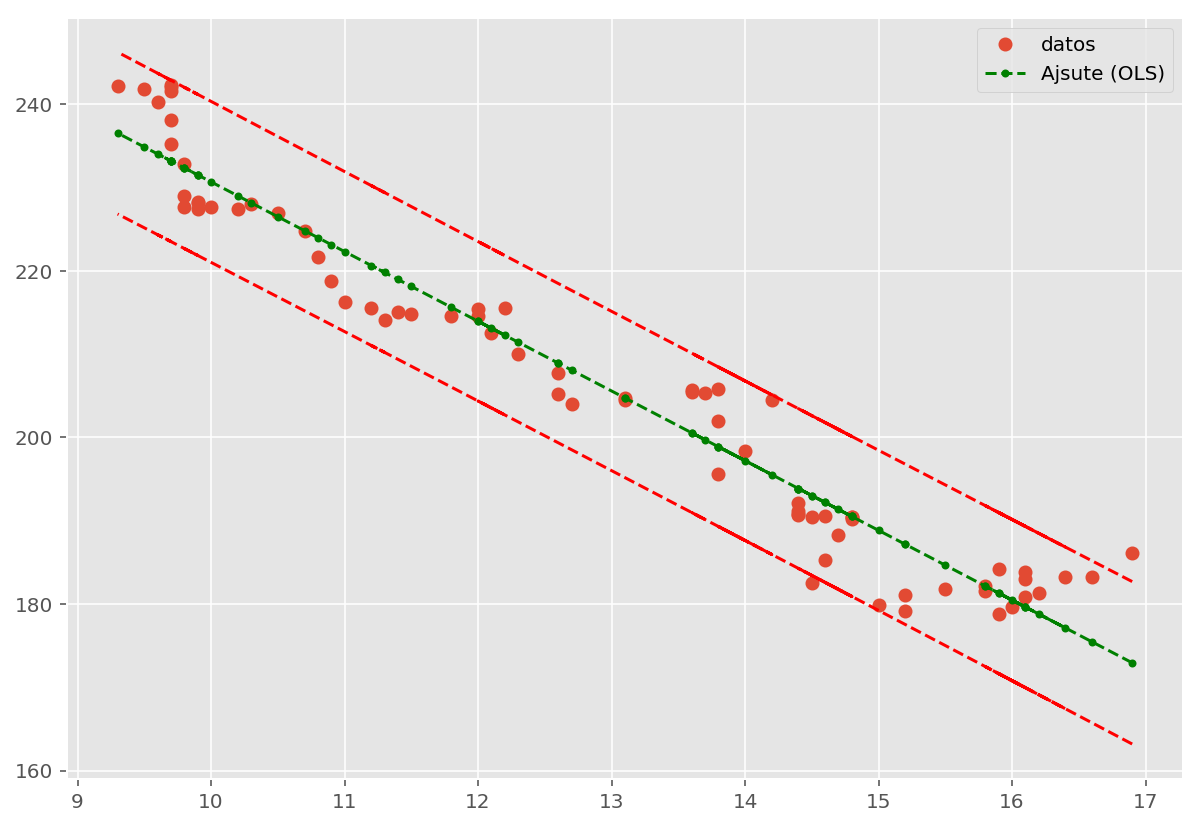

In [76]:
# this produces our trend line

from statsmodels.sandbox.regression.predstd import wls_prediction_std
import numpy as np

# predictor variable
x = df[['total_unemployed']]
# dependent variable
y = df[['housing_price_index']]

# retrieve our confidence interval values
# _ is a dummy variable since we don't actually use it for plotting but need it as a placeholder
# since wls_prediction_std(housing_model) returns 3 values
_, confidence_interval_lower, confidence_interval_upper = wls_prediction_std(housing_model)

fig, ax = plt.subplots(figsize=(10,7))

# plot the dots
# 'o' specifies the shape (circle), we can also use 'd' (diamonds), 's' (squares)
ax.plot(x, y, 'o', label="datos")

# plot the trend line
# g-- and r-- specify the color to use
ax.plot(x, housing_model.fittedvalues, 'g--.', label="Ajsute (OLS)")
# plot upper and lower ci values
ax.plot(x, confidence_interval_upper, 'r--')
ax.plot(x, confidence_interval_lower, 'r--')
# plot legend
ax.legend(loc='best');

# Ampliación 3. Inlcuimos más variables: modelo de regresión lineal múltiple

Nuestro modelo estadístico asume lo siguiente:

$$ Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_k X_K + \epsilon $$

o en su forma matricial:

$$Y = X \beta + \epsilon, \mbox{ donde } \epsilon \sim \mathcal{N} (0, \Sigma) $$

Dependiendo de las propiedades de $\Sigma$, podemos acceder a cuatro clases de estudios:

* GLS : (generalized least squares) matriz de covarianza arbitraria $\Sigma$
* OLS : (ordinary least squares) errores independientes e identicamente distribuidos $\Sigma=\textbf{I}$
* WLS : (weighted least squares) errores heterocedásticos $\text{diag}\left (\Sigma\right)$
* GLSAR : (generalized least squares) con errores autocorrelados de manera AR(p). $\Sigma=\Sigma\left(\rho\right)$

Pueden darse problemas de **multicolinealidad**, es decir, las variables explicativas están altamente correladas, lo que producirá cambios sustanciales en la estimación de los coeficientes de regresion. Esta es una nueva hipótesis que hay que incluir en el modelo: **No multicolinealidad**

Para comprobar si tenemos multicolinealidad o no, mirarémos el **número  de  condición**, que  mide  la  sensibilidad  de  las  estimaciones  mínimocuadráticas  ante  pequeños  cambios  en  los  datos.

http://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

In [77]:
import numpy as np
import pandas as pd

# Puede encontrase el ejemplo completo en http://www.learndatasci.com/predicting-housing-prices-linear-regression-using-python-pandas-statsmodels/

housing_price_index = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/monthly-hpi.csv')
unemployment = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/unemployment-macro.csv')
federal_funds_rate = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/fed_funds.csv')
shiller = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/shiller.csv')
gross_domestic_product = pd.read_csv('https://raw.githubusercontent.com/AngelBerihuete/article-resources/master/Housing%20Price%20Index%20Regression/gdp.csv')

# unimos los DataFrames a través de la variable date

df = shiller.merge(housing_price_index, on='date')\
                    .merge(unemployment, on='date')\
                    .merge(federal_funds_rate, on='date')\
                    .merge(gross_domestic_product, on='date')
            
df.head()

,date,sp500,consumer_price_index,long_interest_rate,housing_price_index,total_unemployed,more_than_15_weeks,not_in_labor_searched_for_work,multi_jobs,leavers,losers,federal_funds_rate,total_expenditures,labor_force_pr,producer_price_index,gross_domestic_product
0,2011-01-01,1282.62,220.22,3.39,181.35,16.2,8393,2800,6816,6.5,60.1,0.17,5766.7,64.2,192.7,14881.3
1,2011-04-01,1331.51,224.91,3.46,180.80,16.1,8016,2466,6823,6.8,59.4,0.10,5870.8,64.2,203.1,14989.6
2,2011-07-01,1325.19,225.92,3.00,184.25,15.9,8177,2785,6850,6.8,59.2,0.07,5802.6,64.0,204.6,15021.1
3,2011-10-01,1207.22,226.42,2.15,181.51,15.8,7802,2555,6917,8.0,57.9,0.07,5812.9,64.1,201.1,15190.3
4,2012-01-01,1300.58,226.66,1.97,179.13,15.2,7433,2809,7022,7.4,57.1,0.08,5765.7,63.7,200.7,15291.0


#### Ajustamos el modelo de regresión múltiple

In [78]:
housing_model = ols("""housing_price_index ~ total_unemployed 
                                            + long_interest_rate 
                                            + federal_funds_rate
                                            + consumer_price_index 
                                            + gross_domestic_product""", data=df).fit()

housing_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     housing_price_index   R-squared:                       0.980
Model:                             OLS   Adj. R-squared:                  0.974
Method:                  Least Squares   F-statistic:                     168.5
Date:                 Thu, 21 Mar 2019   Prob (F-statistic):           7.32e-14
Time:                         19:31:46   Log-Likelihood:                -55.164
No. Observations:                   23   AIC:                             122.3
Df Residuals:                       17   BIC:                             129.1
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -389.2234    187.252     -2.079      0.053    -784.291       5.844
total_unemployed          -0.1727      2.399     -0.072      0.943      -5.234       4.889
long_interest_rate         5.4326      1.524      3.564      0.002       2.216       8.649
federal_funds_rate        32.3750      9.231      3.507      0.003      12.898      51.852
consumer_price_index       0.7785      0.360      2.164      0.045       0.020       1.537
gross_domestic_product     0.0252      0.010      2.472      0.024       0.004       0.047
==============================================================================
Omnibus:                        1.363   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.506   Jarque-Bera (JB):                1.043
Skew:                          -0.271   Prob(JB):                        0.594
Kurtosis:                       2.109   Cond. No.                     4.58e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

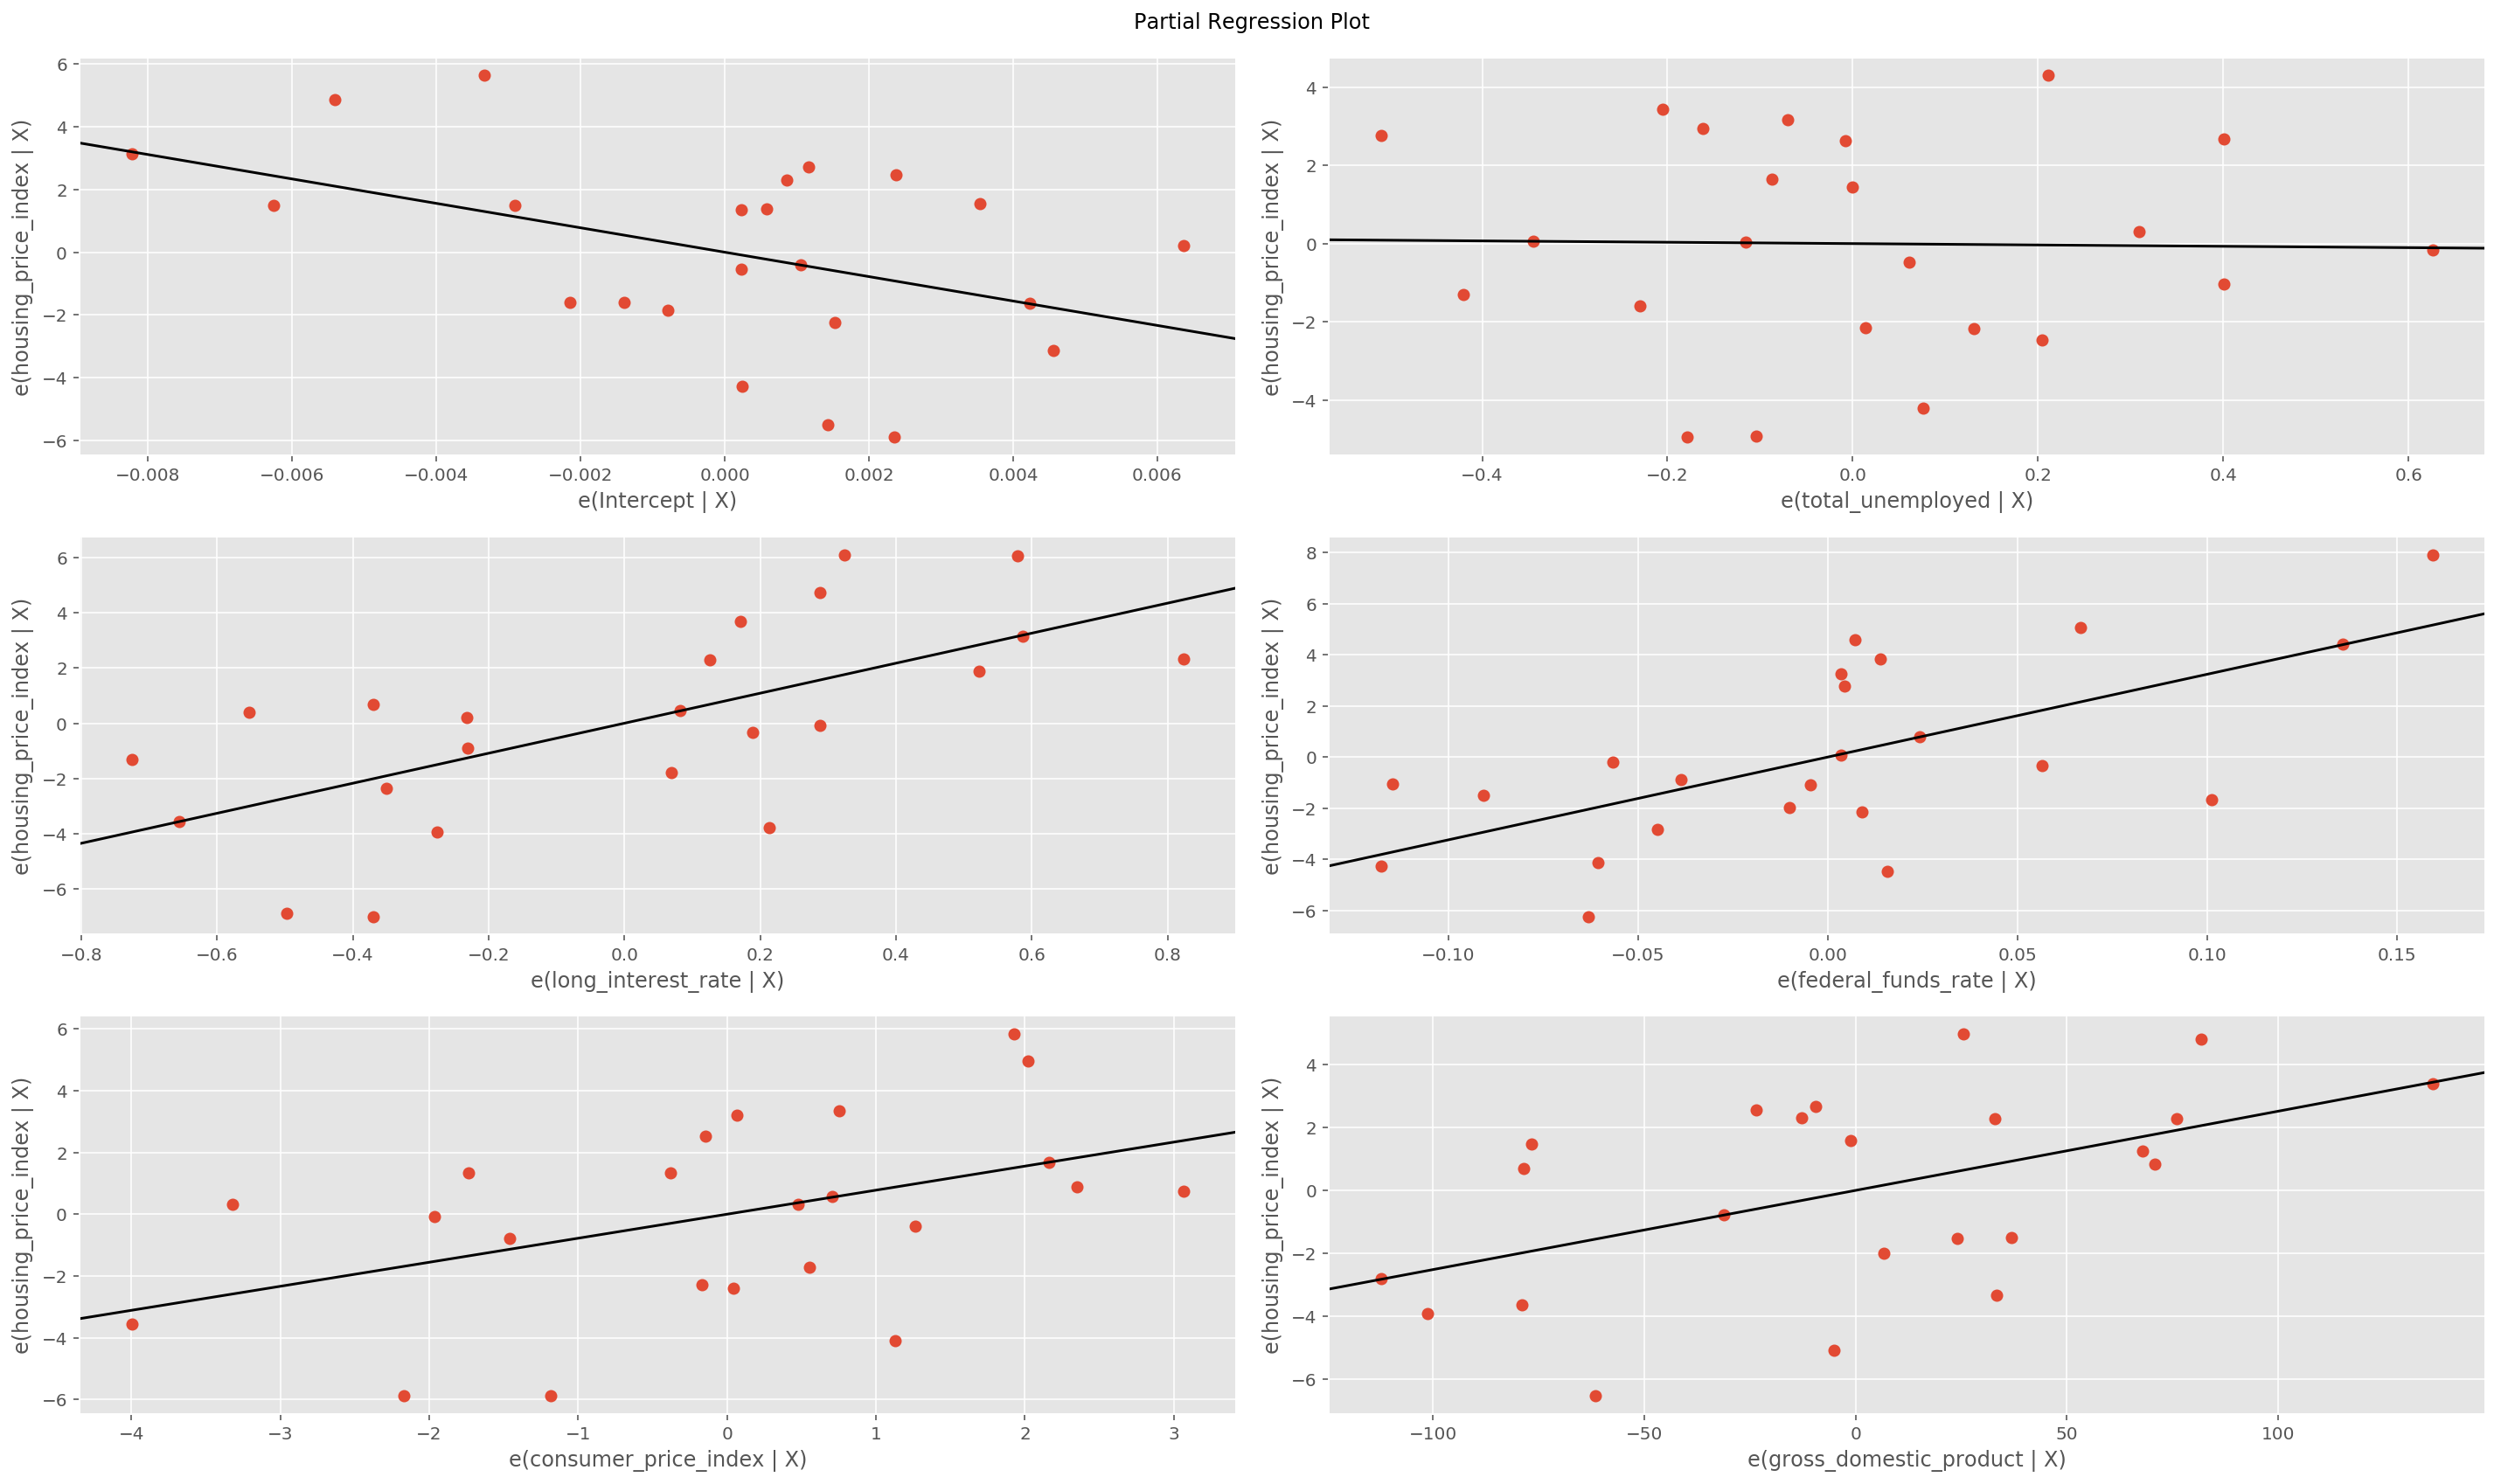

In [79]:
fig = plt.figure(figsize=(20,12))
fig = sm.graphics.plot_partregress_grid(housing_model, fig=fig)